In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('./../src/')
from manuscript import flow_sankey as sankey
from manuscript import datasets, inout, export


import itertools
import scipy.stats
import statsmodels.stats.multitest
import statannotations.Annotator

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")
        
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


def dump_table(df, name):
    export.full_frame(
        user, 
        f'{outfolder}/{name}', 
        df, 
        index=True,
        date=True
    )

def dump_figure(name):
    export.image(
        user,
        f'{outfolder}/{name}',
    )

In [2]:
DISCH_PALETTE = [
    "tab:blue", #home
    "lightseagreen", #rehab
    "beige", #snf
    "gold",#ltach
    "orange",#hospice
    "crimson",#died 
]

In [3]:
user = 'CAG'     # defines top hierarchy of output folder
outfolder = '10_VAP_transitions'    # name of notebook

In [4]:
data = pd.read_csv(
    inout.get_material_path('general/05_join_clusters_umap/05_data_umap_clusters_220908_1554.csv.gz'), 
    index_col=0
)

In [5]:
# match old naming

data.Binary_outcome.replace({1: "Died", 0: 'Alive'}, inplace=True)

data.Discharge_disposition = data.Discharge_disposition.astype("category")
data.Discharge_disposition = data.Discharge_disposition.cat.reorder_categories([
    'Home', 
    'Rehab', 
    'SNF', 
    'LTACH',
    'Hospice', 
    'Died'
])

data = data.rename(columns={
    'Patient_id': 'patient',
    'ICU_stay': 'stay',
    'ICU_day': 'day',
    'clusters': 'cluster'
})

# Ensure order
data.sort_values(["patient", "stay", "day"], inplace=True)

## Create intermediate data

A dataframe for each day around each VAP episode: in which clusters were the patients.

At the same time, check if any other pneumonia episode is overlapping

In [6]:
dfs = []
for day in range(-2, 8):
    days = data.day[data.Episode_category.eq("VAP") & data.Episode_etiology.ne("Viral")] + day
    days = days[days > 0]
    idx = (
        data.patient[days.index].astype(str) 
        + "/" + data.stay[days.index].astype(str) 
        + "/" + days.astype(str)
    )
    idx = idx[idx.isin(data.index)]
    df = pd.DataFrame({
        "cluster": data.cluster[idx].values,
        "next_cluster": data.next_cluster[idx].values,
        "episode_type": data.Episode_category[idx.index].values,
        "day": day
    }, index=idx.index)
    if day != 0:
        overlapping = data.loc[idx, ["Episode_category"]]
        overlapping["current_ep"] = idx.index.values
        overlapping = overlapping.loc[overlapping.Episode_category.isin(["CAP", "HAP", "VAP"]), :]
        if overlapping.shape[0] > 0:
            n_overlapping = (~overlapping.Episode_category.isna()).sum()
            print(f"{n_overlapping} overlapping episodes on day {day}")
            for i, row in overlapping.iterrows():
                print(f"On day {day} of {row.current_ep} VAP episode there was {i} episode")
            print()
    full_idx = data.index[data.Episode_category.eq("VAP") & data.Episode_etiology.ne("Viral")]
    df = df.reindex(full_idx)
    df.loc[full_idx[~full_idx.isin(idx.index)], "day"] = day
    df.loc[full_idx[~full_idx.isin(idx.index)], "episode_type"] = "VAP"
    df.loc[full_idx, "cured"] = data.Episode_is_cured[full_idx]
    df.loc[full_idx, "patient"] = data.patient[full_idx]
    df.loc[full_idx, "stay"] = data.stay[full_idx]
    df.loc[full_idx, "outcome"] = data.Binary_outcome[full_idx]
    dfs.append(df)
df = pd.concat(dfs)

1 overlapping episodes on day 7
On day 7 of 887/1/13 VAP episode there was 887/1/20 episode



In [7]:
df.shape

(2790, 8)

# Does Cured VAP lead to significantly favorable transitions?

We will take all VAP episodes, and summarize transition deltas from day 0 to day X (7 or before).

Do it for 3 cured categories, and test statistical differences

#### Add mortality data

In [8]:
df.loc[df.next_cluster.eq(-1), "next_cluster"] = np.nan

In [9]:
cluster_mortality = pd.read_csv(
    inout.get_material_path('general/04_clustering/Similarity-cluster_mortality_220908_1540.csv.gz'), 
    index_col=0
)

In [10]:
cluster_mortality['clusters'] = cluster_mortality['index'] + 1

In [11]:
cluster_mortality = cluster_mortality[['clusters', 'mortality']]

In [12]:
cluster_mortality = cluster_mortality.set_index("clusters")

In [13]:
df.loc[~df.cluster.isna(), "mortality"] = cluster_mortality.mortality[df.cluster[~df.cluster.isna()]].values

In [14]:
df.loc[~df.next_cluster.isna(), "next_mortality"] = cluster_mortality.mortality[
    df.next_cluster[~df.next_cluster.isna()]
].values

In [15]:
df.loc[
    df.next_cluster.isna() & df.outcome.eq("Alive"),
    "next_mortality"
] = 0

In [16]:
df.loc[
    df.next_cluster.isna() & df.outcome.eq("Died"),
    "next_mortality"
] = 1

In [17]:
df = df.loc[df.day >= 0].copy()

In [18]:
df["mortality_delta"] = df.next_mortality - df.mortality

In [19]:
df.mortality_delta.fillna(0, inplace=True)

In [20]:
df["episode_start"] = df.index

In [21]:
def vap_transitions(df, day):
    df = df.loc[df.day <= day]
    stat_df = df.groupby(["cured", "episode_start"]).mortality_delta.sum().reset_index()
    stat_results = []
    for d1, d2 in itertools.combinations(stat_df.cured.unique(), 2):
        days1 = stat_df.mortality_delta[stat_df.cured.eq(d1)]
        days2 = stat_df.mortality_delta[stat_df.cured.eq(d2)]
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stat_results.append([d1, d2, days1.size, days2.size, pval])
    stat_results = pd.DataFrame(stat_results, columns=["group1", "group2",
                                                       "group1_size", "group2_size", "pval"])
    stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
    stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]
    pairs = []
    for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
    
    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
    sns.boxplot(
        data=stat_df, 
        x="cured",
        y="mortality_delta", 
        ax=ax, 
        saturation=1, 
        palette=[DISCH_PALETTE[0], DISCH_PALETTE[3], DISCH_PALETTE[-1]],
        linewidth=1
    )
    for a in ax.collections:
        if isinstance(a, mpl.collections.PatchCollection):
            # remove line surround each box
            a.set_linewidth(0)
    ax.set_ylabel("Sum of transitions", size=16)
    ax.set_xlabel("")
    ax.tick_params(axis="x", labelsize=14)
    # ax.set_xticklabels(["non-COVID", "COVID"], size=16)
    # ax.legend(loc="upper left", title="Outcome", frameon=False, fontsize=14, title_fontsize=12)
    # ax.legend_.set_bbox_to_anchor((1, 0.8))
    ax.set_title(f"Distribution of sum of transitions for first {day} days after episode", size=16)
    annotator = statannotations.Annotator.Annotator(
        ax, 
        pairs, 
        data=stat_df, 
        x="cured",
        y="mortality_delta", 
        verbose=False
    )
    annotator._verbose = False
    annotator.configure(line_width=1)
    annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
    annotator.annotate();
    return ax

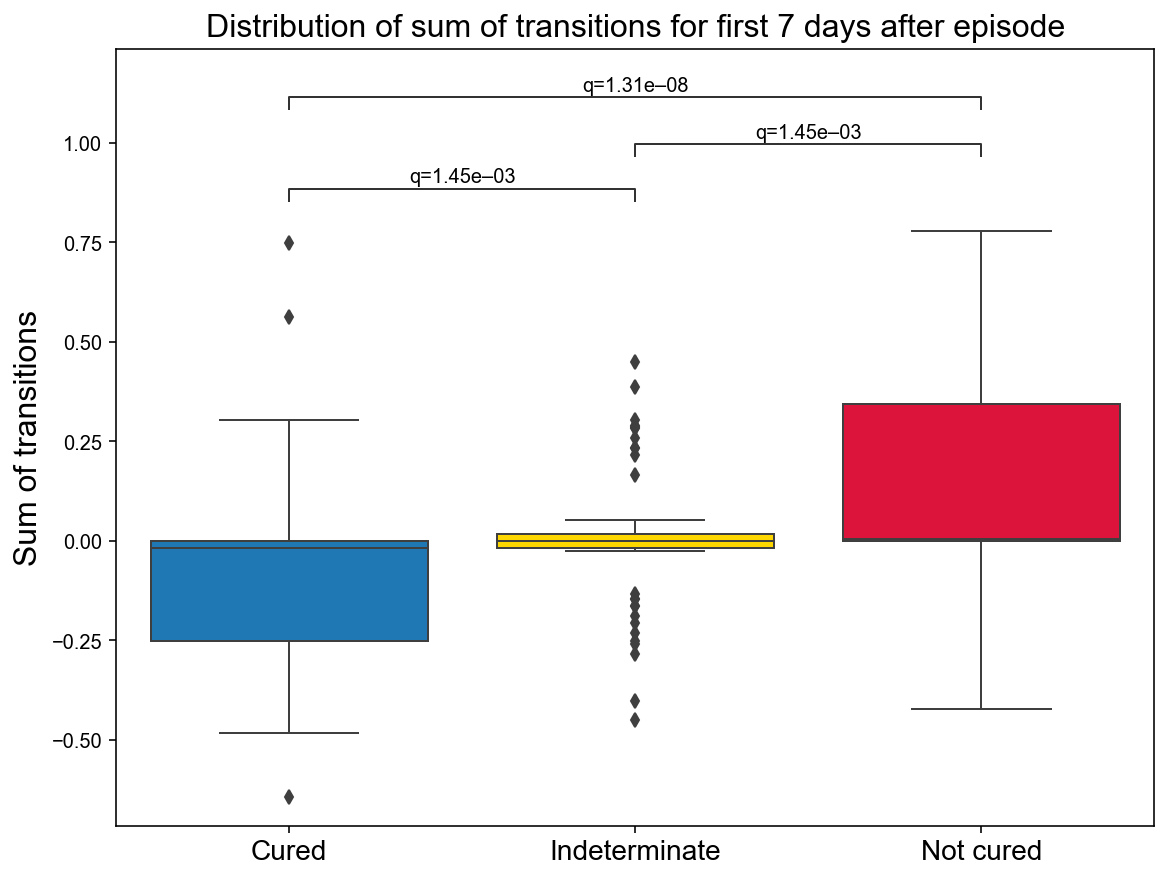

In [22]:
vap_transitions(df, 7)
dump_figure("vap_sum_of_trans_7days.pdf")

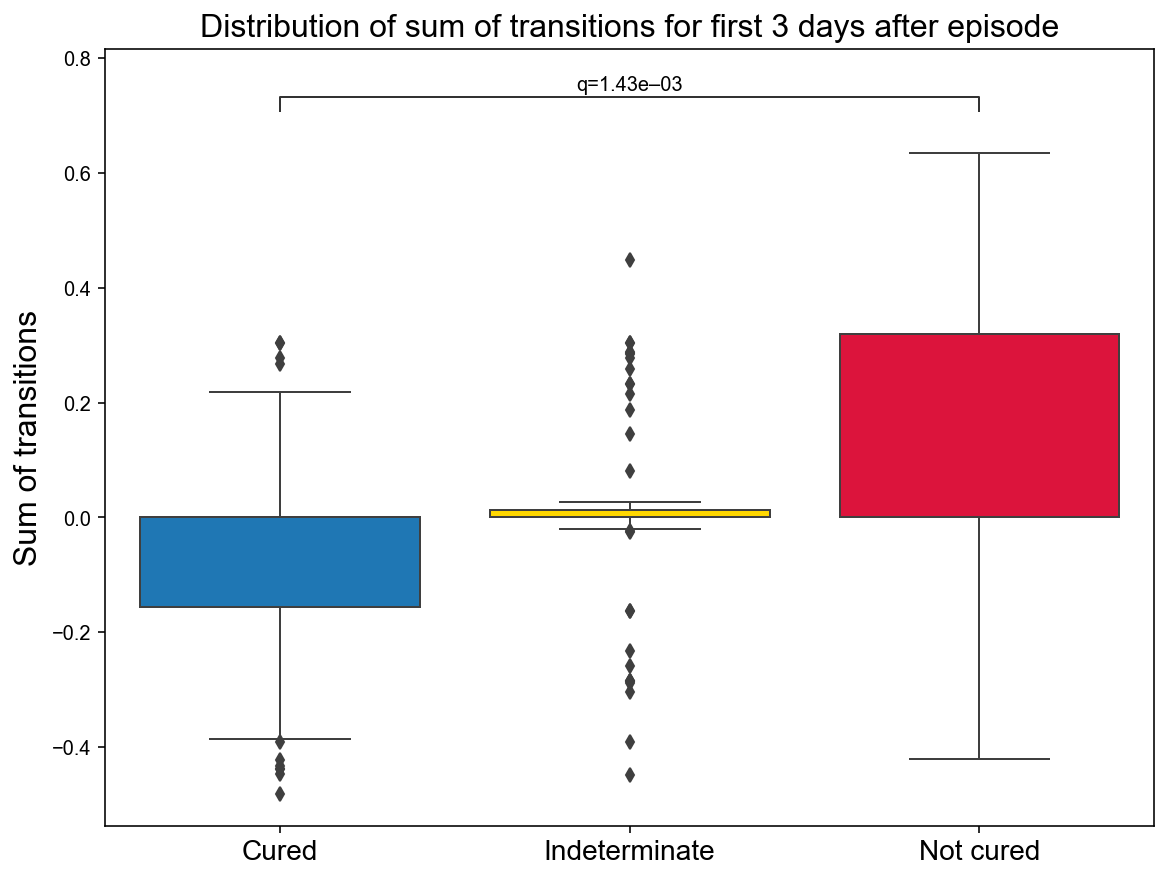

In [23]:
vap_transitions(df, 3)
dump_figure("vap_sum_of_trans_3days.pdf")

<AxesSubplot:title={'center':'Distribution of sum of transitions for first 4 days after episode'}, ylabel='Sum of transitions'>

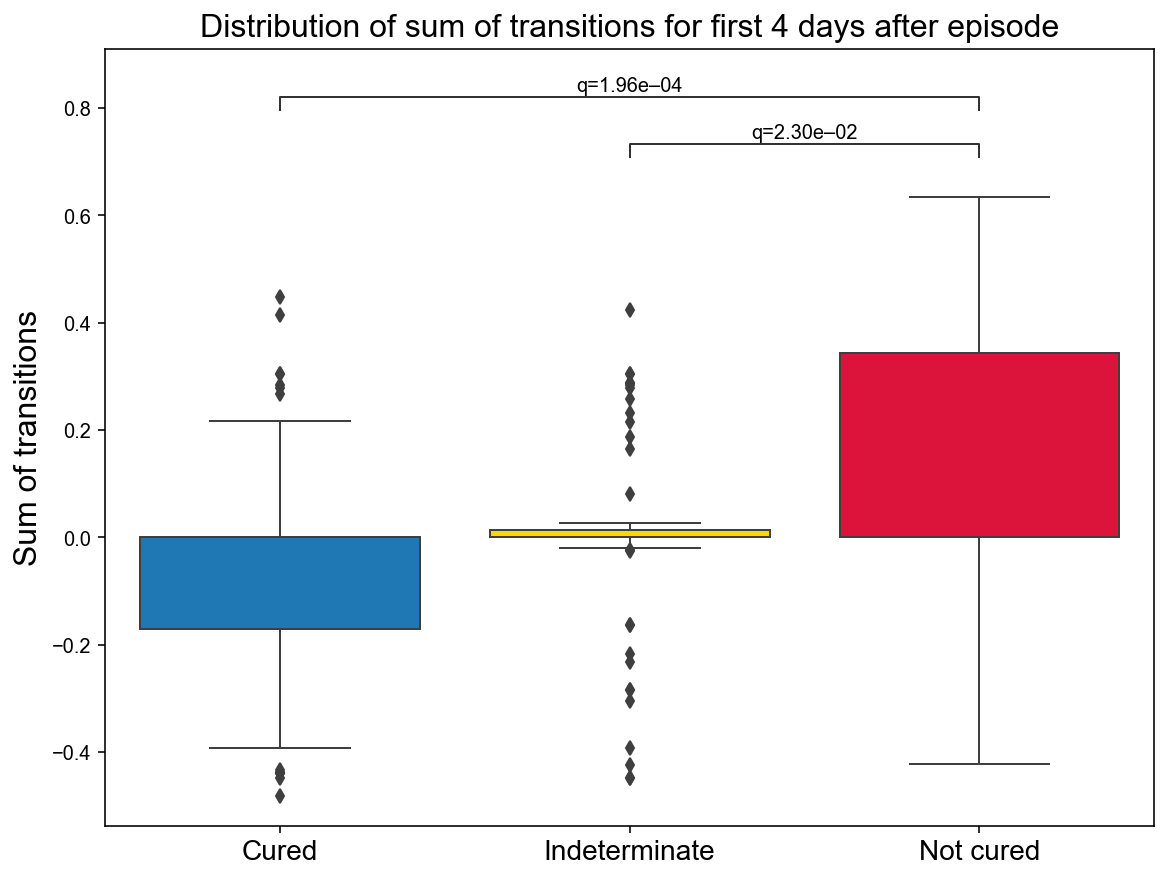

In [24]:
vap_transitions(df, 4)

<AxesSubplot:title={'center':'Distribution of sum of transitions for first 5 days after episode'}, ylabel='Sum of transitions'>

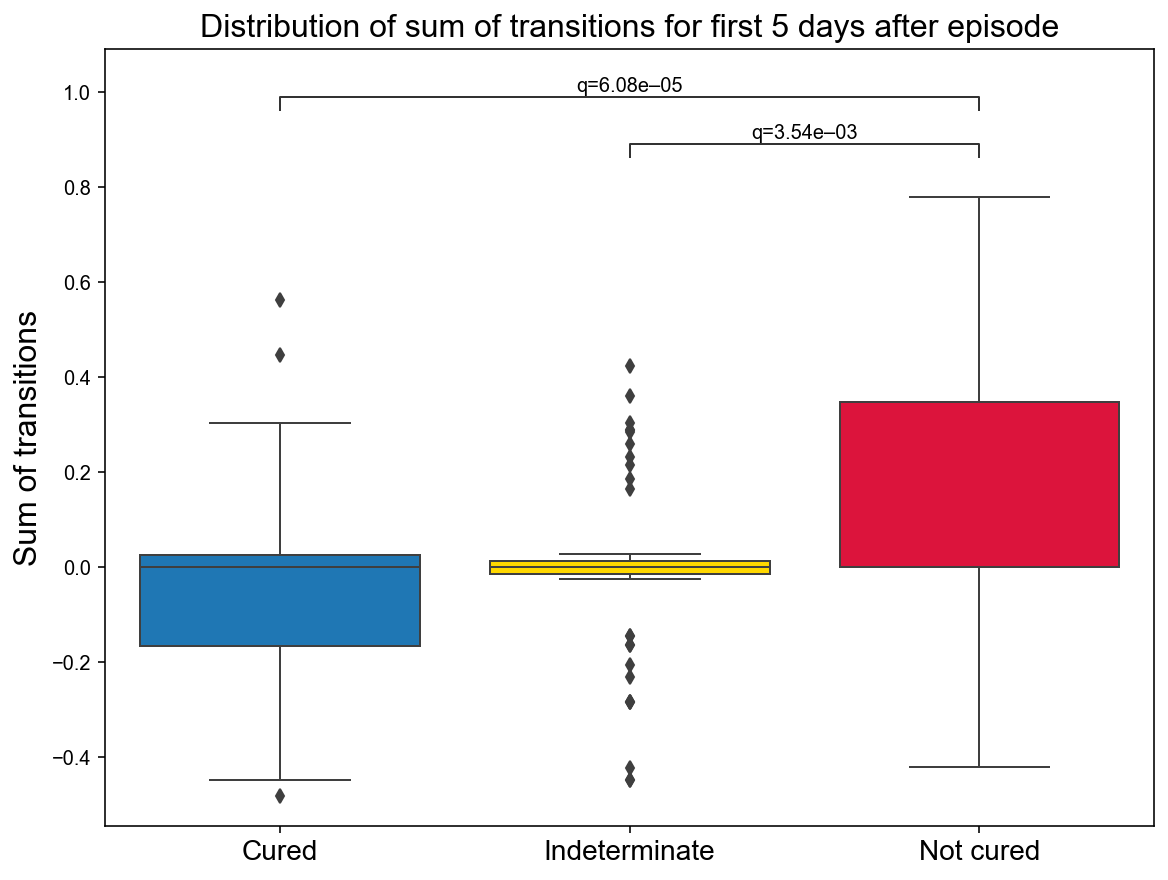

In [25]:
vap_transitions(df, 5)

<AxesSubplot:title={'center':'Distribution of sum of transitions for first 6 days after episode'}, ylabel='Sum of transitions'>

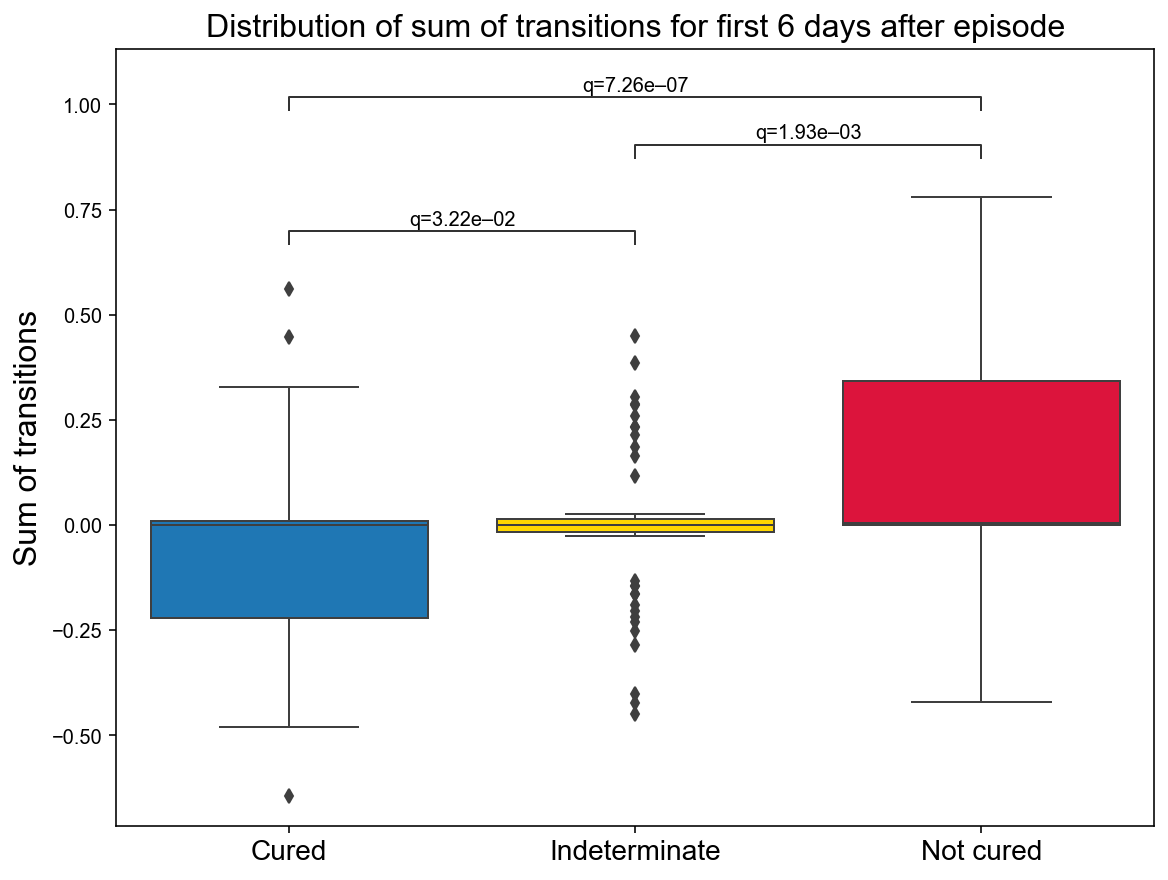

In [26]:
vap_transitions(df, 6)

## Plot distribution of transition sums per day

In [27]:
def transtion_sums(df, day):
    CURED_MAP = {
        "Cured": 1,
        "Indeterminate": 0,
        "Not cured": -1
    }
    df = df.loc[df.day <= day]
    df = df.groupby(["cured", "episode_start"]).mortality_delta.sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
    ax.scatter(
        df.mortality_delta,
        df.cured.map(CURED_MAP) + np.random.uniform(low=-0.2, high=0.2, size=df.shape[0]),
        c=[mpl.cm.tab10(x + 1) for x in df.cured.map(CURED_MAP)]
    )
    ax.set_xlabel("Sum of transitions", size=16)
    ax.set_title(f"Distribution of sum of transitions for first {day} days after episode", size=16)
    ax.set_yticks(list(CURED_MAP.values()))
    ax.set_yticklabels(list(CURED_MAP.keys()), size=16)
    return ax

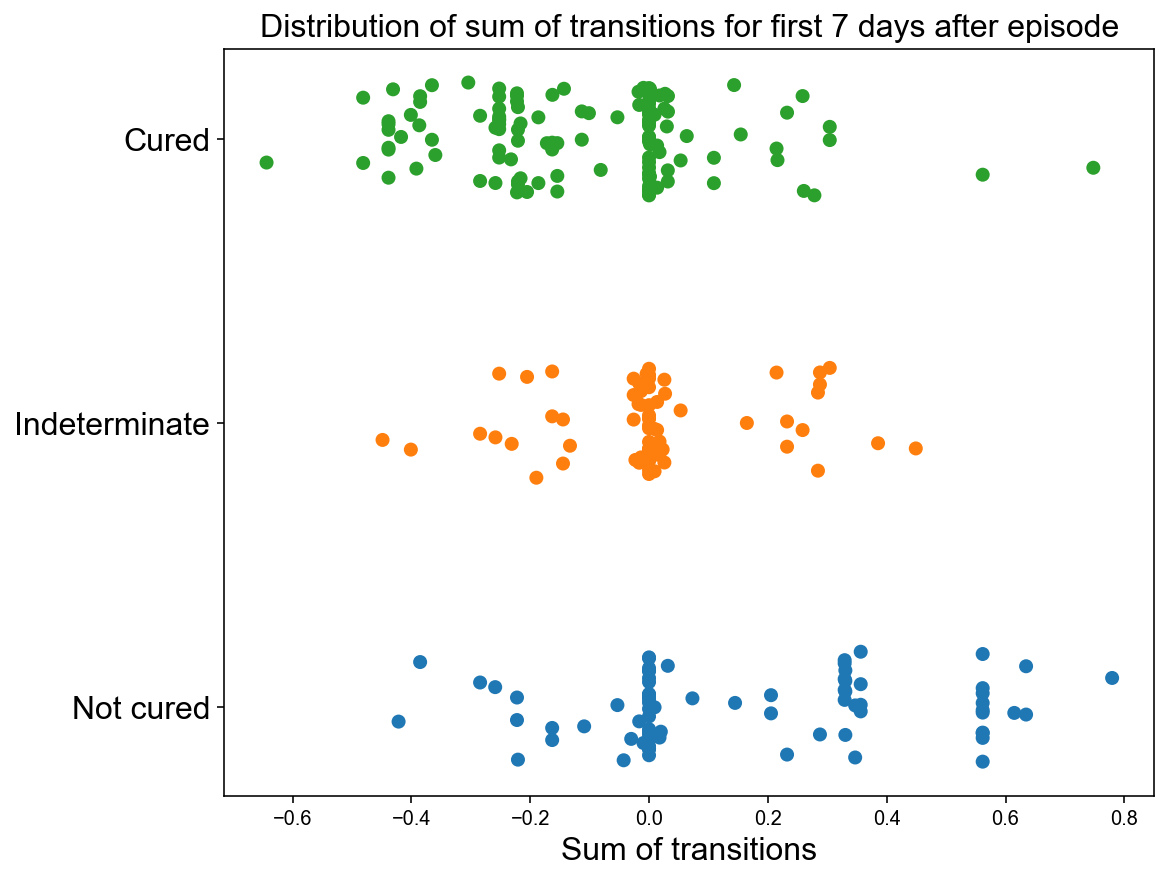

In [28]:
transtion_sums(df, 7);

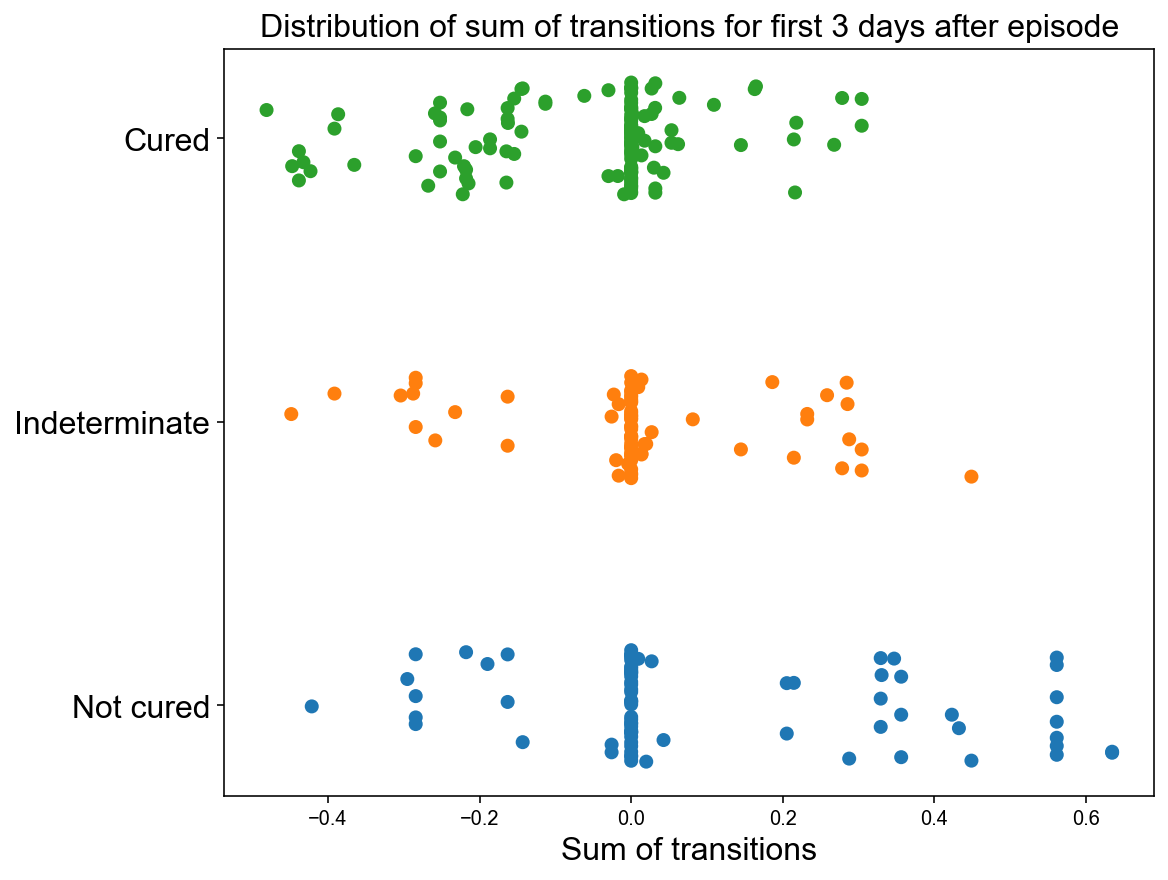

In [29]:
transtion_sums(df, 3);

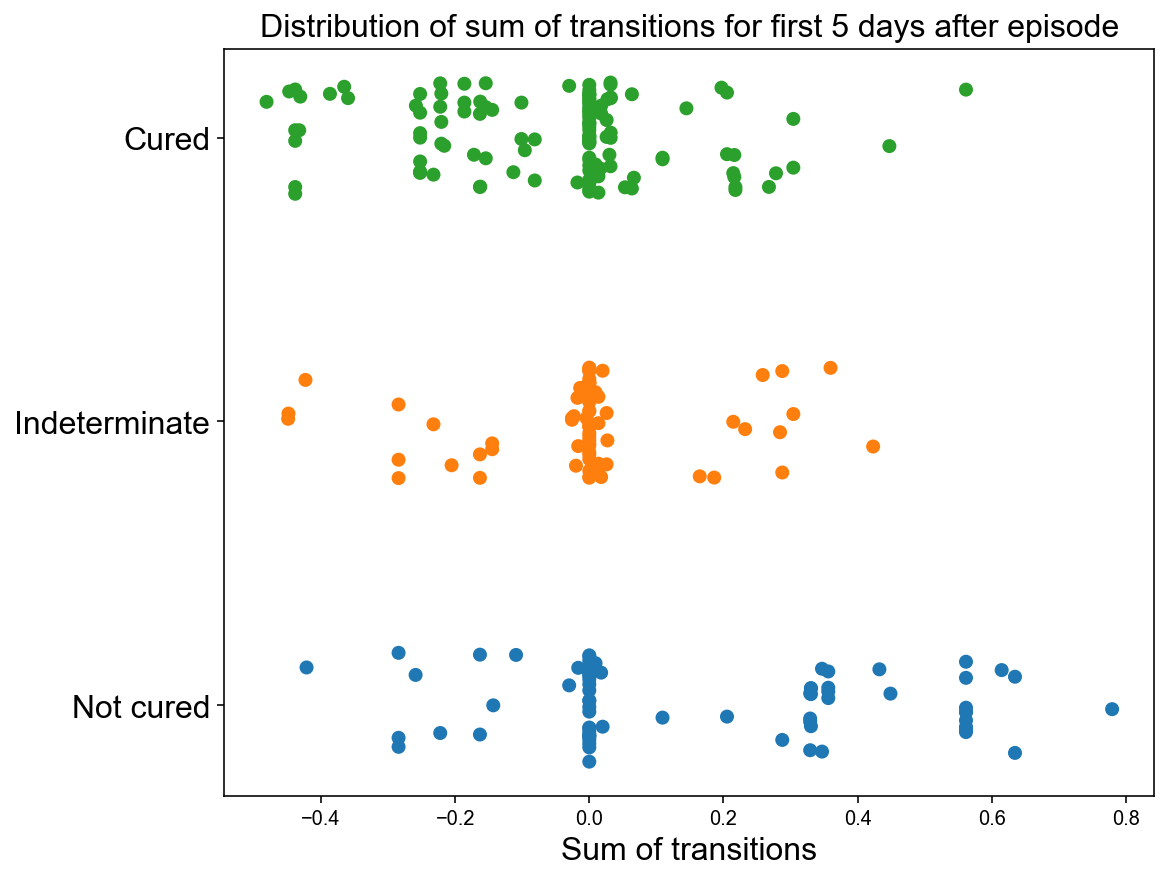

In [30]:
transtion_sums(df, 5);

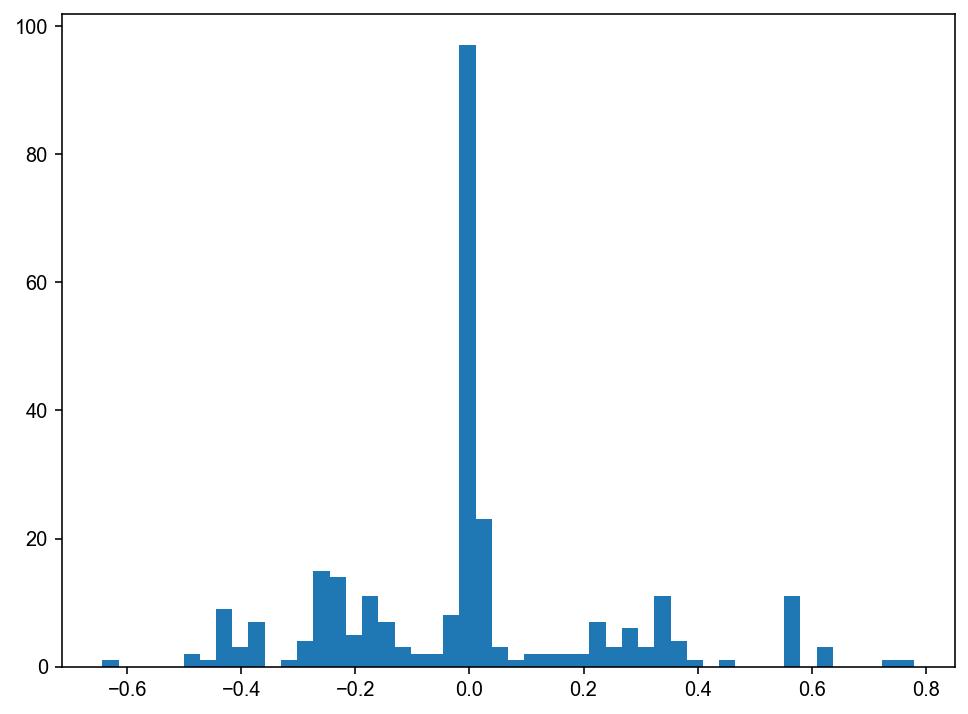

In [31]:
plot_df = df.loc[df.day <= 7]
plot_df = plot_df.groupby(["cured", "episode_start"]).mortality_delta.sum().reset_index()
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(plot_df.mortality_delta, bins=50);

In [32]:
plot_df.loc[plot_df.mortality_delta < -0.1].cured.value_counts()

Cured            61
Indeterminate    13
Not cured        10
Name: cured, dtype: int64

In [33]:
plot_df.loc[
    plot_df.mortality_delta < -0.1
].cured.value_counts() / plot_df.groupby("cured").episode_start.count()

Cured            0.476562
Indeterminate    0.178082
Not cured        0.128205
dtype: float64

In [34]:
plot_df.loc[
    (plot_df.mortality_delta < 0.1)
    & (plot_df.mortality_delta >= -0.1)
].cured.value_counts()

Cured            53
Indeterminate    48
Not cured        34
Name: cured, dtype: int64

In [35]:
plot_df.loc[
    (plot_df.mortality_delta < 0.1)
    & (plot_df.mortality_delta >= -0.1)
].cured.value_counts() / plot_df.groupby("cured").episode_start.count()

Cured            0.414062
Indeterminate    0.657534
Not cured        0.435897
dtype: float64

In [36]:
plot_df.loc[
    (plot_df.mortality_delta >= 0.1)
].cured.value_counts()

Not cured        34
Cured            14
Indeterminate    12
Name: cured, dtype: int64

In [37]:
plot_df.loc[
    (plot_df.mortality_delta >= 0.1)
].cured.value_counts() / plot_df.groupby("cured").episode_start.count()

Cured            0.109375
Indeterminate    0.164384
Not cured        0.435897
dtype: float64

In [38]:
plot_df["delta_group"] = "Low"
plot_df.loc[
    (plot_df.mortality_delta < 0.1) & (plot_df.mortality_delta >= -0.1),
    "delta_group"
] = "Medium"
plot_df.loc[
    (plot_df.mortality_delta >= 0.1),
    "delta_group"
] = "High"

In [39]:
plot_df2 = plot_df.groupby(["delta_group", "cured"]).agg({"cured": "count"}).rename(
    {"cured": "cnt"}, axis="columns"
).reset_index()

In [40]:
stat_results = []
for g1, g2 in itertools.combinations(plot_df2.delta_group.unique(), 2):
    g1_vals = plot_df2.loc[plot_df2.delta_group.eq(g1)].sort_values("cured").cnt.values
    g2_vals = plot_df2.loc[plot_df2.delta_group.eq(g2)].sort_values("cured").cnt.values
    _, pval, _, _ = scipy.stats.chi2_contingency([g1_vals, g2_vals])
    stat_results.append([g1, g2, pval])

In [41]:
stat_results = pd.DataFrame(stat_results, columns=["group1", "group2", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))

In [42]:
plot_df2.cnt /= plot_df.groupby("delta_group").episode_start.count()[plot_df2.delta_group].values

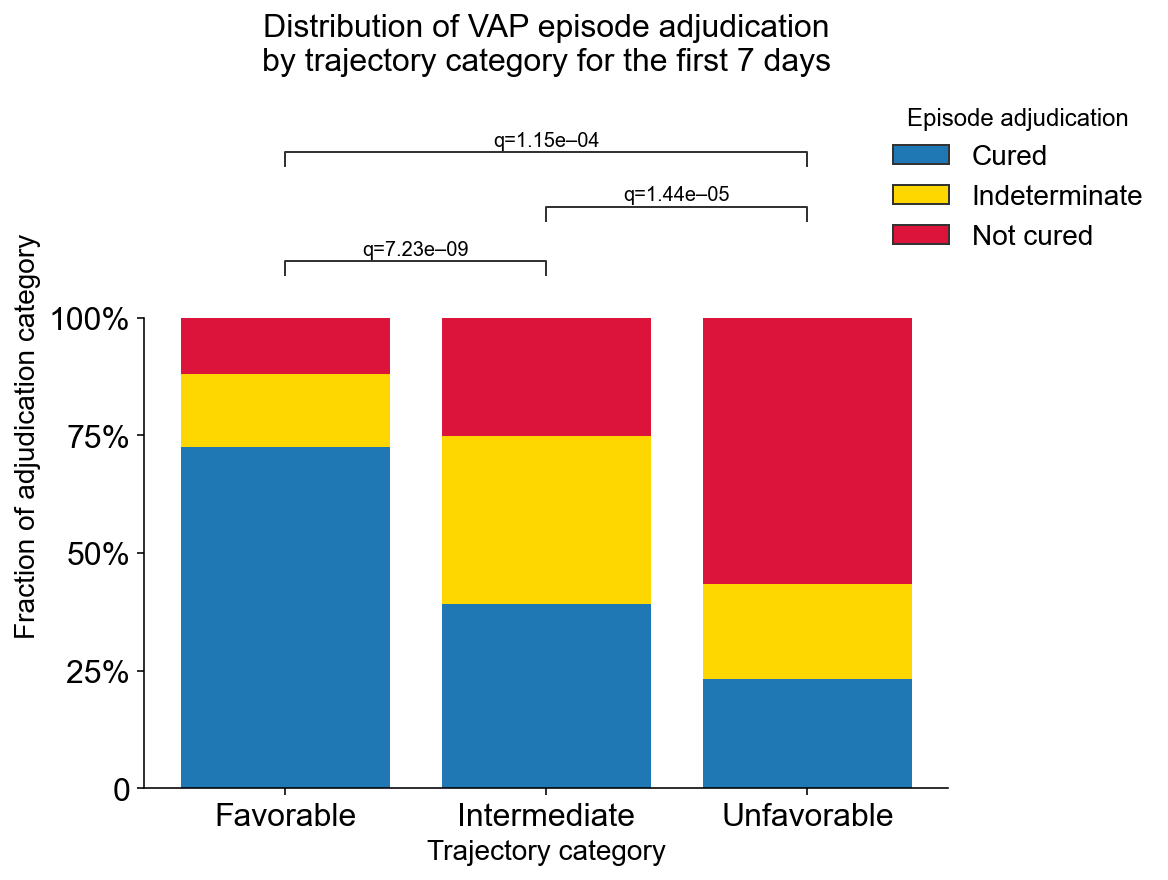

In [43]:
# Stupid seaborn / matplotlib
# I should really submit a pull request to seaborn
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
bottom = np.array([0, 0, 0]).astype(float)
ax.bar([2, 0, 1], plot_df2.cnt[plot_df2.cured.eq("Cured")], 
       color=DISCH_PALETTE[0])
bottom += plot_df2.cnt[plot_df2.cured.eq("Cured")].values
ax.bar([2, 0, 1], plot_df2.cnt[plot_df2.cured.eq("Indeterminate")], 
       color=DISCH_PALETTE[3], bottom=bottom)
bottom += plot_df2.cnt[plot_df2.cured.eq("Indeterminate")].values
ax.bar([2, 0, 1], plot_df2.cnt[plot_df2.cured.eq("Not cured")], 
       color=DISCH_PALETTE[-1], bottom=bottom)
ax.set_xlabel("Trajectory category", size=14)
ax.set_ylabel("Fraction of adjudication category", size=14)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(
    [
        "Favorable", 
        "Intermediate", 
        "Unfavorable"], 
    size=16
)
# ax.set_ylabel("Percentage of episode adjudication", size=14)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels(["0", "25%", "50%", "75%", "100%"], size=16)
ax.set_ylim(0, 1.5)
ax.set_title(
    "Distribution of VAP episode adjudication\nby trajectory category for the first 7 days",
    size=16
)
handles = [
    mpl.patches.Patch(color=DISCH_PALETTE[0], label="Cured", ec="#333333"),
    mpl.patches.Patch(color=DISCH_PALETTE[3], label="Indeterminate", ec="#333333"),
    mpl.patches.Patch(color=DISCH_PALETTE[-1], label="Not cured", ec="#333333")
]
ax.legend(
    handles=handles, 
    loc="upper left", 
    title="Episode adjudication", 
    frameon=False,
    fontsize=14,
    title_fontsize=12,
    bbox_to_anchor=(0.9, 1)
)
ax.spines[["top", "right"]].set_visible(False)
ax.spines["left"].set_bounds((0, 1))
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=plot_df2, 
    x="delta_group",
    y="cnt", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate()
dump_figure("vap_episode_adjudication_by_trajectory.pdf")

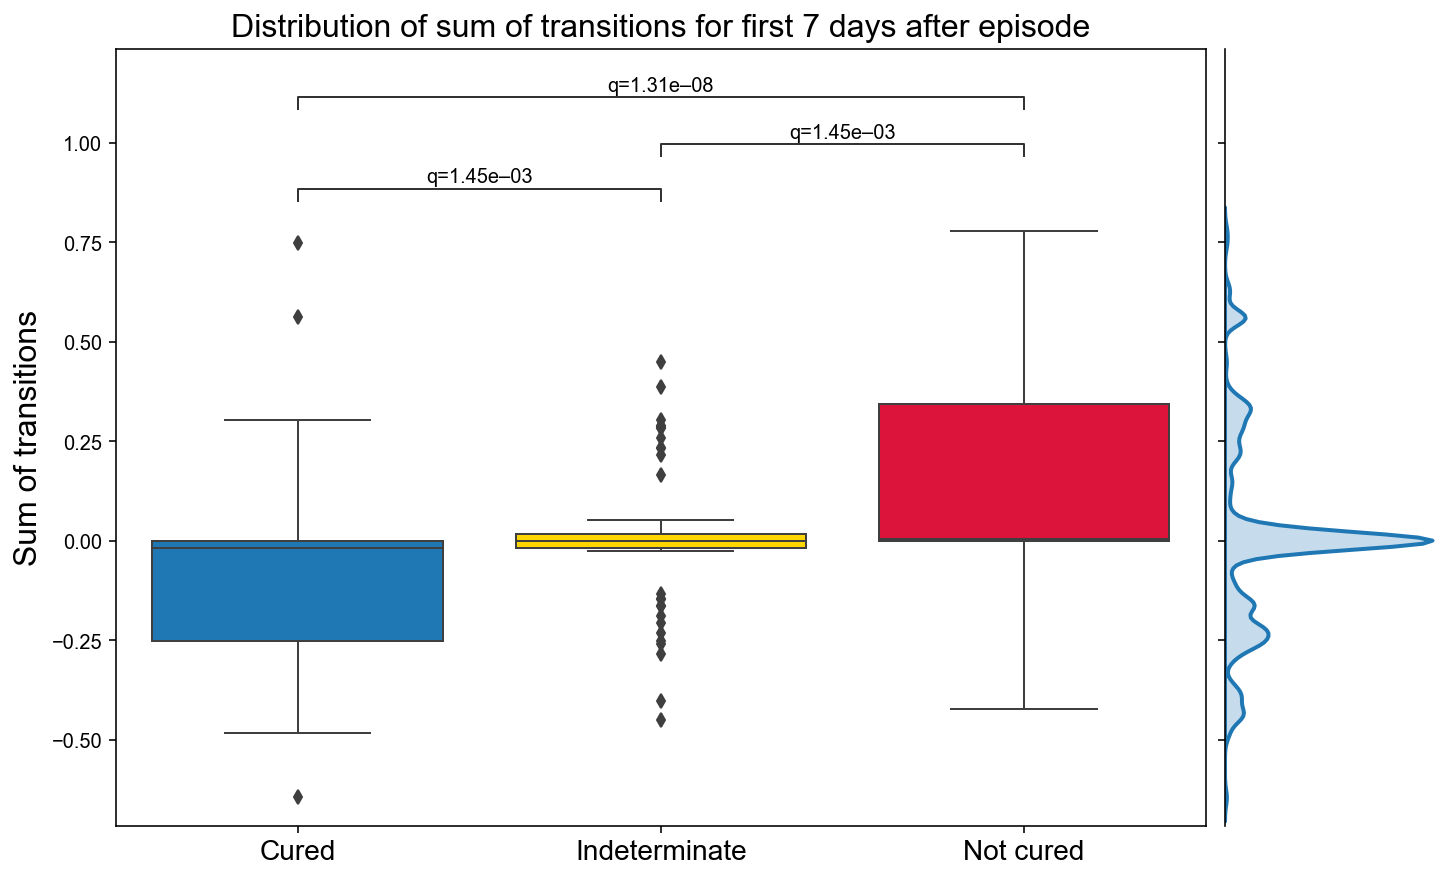

In [44]:
df = df.loc[df.day <= 7]
stat_df = df.groupby(["cured", "episode_start"]).mortality_delta.sum().reset_index()
stat_results = []
for d1, d2 in itertools.combinations(stat_df.cured.unique(), 2):
    days1 = stat_df.mortality_delta[stat_df.cured.eq(d1)]
    days2 = stat_df.mortality_delta[stat_df.cured.eq(d2)]
    if days1.size == 0 or days2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append([d1, d2, days1.size, days2.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
    pairs.append((r.group1, r.group2))

fig, axes = plt.subplots(
    ncols=2, 
    figsize=(10, 6), 
    constrained_layout=True,
    sharey=True,
    gridspec_kw={"wspace": 0, "width_ratios": [1, 0.2]}
)
ax = axes[0]
sns.boxplot(
    data=stat_df, 
    x="cured",
    y="mortality_delta", 
    ax=ax, 
    saturation=1, 
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[3], DISCH_PALETTE[-1]],
    linewidth=1
)
for a in ax.collections:
    if isinstance(a, mpl.collections.PatchCollection):
        # remove line surround each box
        a.set_linewidth(0)
ax.set_ylabel("Sum of transitions", size=16)
ax.set_xlabel("")
ax.tick_params(axis="x", labelsize=14)
# ax.set_xticklabels(["non-COVID", "COVID"], size=16)
# ax.legend(loc="upper left", title="Outcome", frameon=False, fontsize=14, title_fontsize=12)
# ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.set_title(f"Distribution of sum of transitions for first {day} days after episode", size=16)
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=stat_df, 
    x="cured",
    y="mortality_delta", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate();
sns.kdeplot(data=stat_df, y="mortality_delta", ax=axes[1], bw_adjust=0.25, fill=True, lw=2)
axes[1].spines[["top", "right", "bottom"]].set_visible(False)
axes[1].set_xticks([])
axes[1].set_xlabel("");
dump_figure("vap_sum_of_trans_7days_with_side.pdf")

## Look at transitions before VAP and the chance of negative transition

### Baseline

In [45]:
data["bad_transition"] = np.nan

In [46]:
data.loc[data.next_cluster > data.cluster, "bad_transition"] = "bad"

In [47]:
data.loc[data.next_cluster.lt(data.cluster) & data.next_cluster.ne(-1), "bad_transition"] = "good"

In [48]:
data.bad_transition.value_counts(dropna=False)

NaN     9347
bad     1655
good    1493
Name: bad_transition, dtype: int64

In [49]:
data.is_transition.sum() == data.bad_transition.isin(["good", "bad"]).sum()

True

Probability of bad transition

In [50]:
data.bad_transition.eq("bad").sum() / data.next_cluster.ne(-1).sum()

0.1410190865712338

Probability of good transition

In [51]:
data.bad_transition.eq("good").sum() / data.next_cluster.ne(-1).sum()

0.12721540558963873

Probability of no transition

In [52]:
data.bad_transition[data.next_cluster.ne(-1)].isna().sum() / data.next_cluster.ne(-1).sum()

0.7317655078391274

Sanity checks

In [53]:
0.7317655078391274 + 0.12721540558963873 + 0.1410190865712338

1.0

### Day -1 before VAP

In [100]:
vap_df = data.loc[data.Episode_category.eq("VAP")].copy()

In [101]:
vap_df["prev_day"] = vap_df.day - 1

In [102]:
vap_df = vap_df.loc[vap_df.prev_day > 0].copy()

In [103]:
vap_df.shape

(311, 80)

In [104]:
data.Episode_category.eq("VAP").sum()

328

Out of 328 VAP episodes we have 311 that have a previous day in the ICU

In [105]:
vap_df["prev_day_idx"] = (
    vap_df.patient.astype(str) 
    + "/" + vap_df.stay.astype(str)
    + "/" + vap_df.prev_day.astype(str)
)

In [106]:
vap_df = vap_df.loc[vap_df.prev_day_idx.isin(data.index)]

In [107]:
vap_df.prev_day_idx.isin(data.index).sum()

310

In [108]:
day_before_vap = data.loc[vap_df.prev_day_idx]

Probability of bad transition

In [109]:
day_before_vap.bad_transition.eq("bad").sum() / day_before_vap.shape[0]

0.2032258064516129

Probability of good transition

In [110]:
day_before_vap.bad_transition.eq("good").sum() / day_before_vap.shape[0]

0.13225806451612904

In [111]:
day_before_vap

,patient,External_transfer_flag,Admission_source_name,Discharge_disposition,Binary_outcome,Global_cause_failure,Patient_category,COVID_status,Age,Ethnicity,Gender,Race,Smoking_status,BMI,Admit_APS_score,Admit_SOFA_score,Cumulative_ICU_days,Number_of_ICU_stays,Tracheostomy_flag,Cumulative_intubation_days,stay,day,SOFA_score,ECMO_flag,Intubation_flag,Hemodialysis_flag,CRRT_flag,Temperature,Heart_rate,Systolic_blood_pressure,Diastolic_blood_pressure,Mean_arterial_pressure,Norepinephrine_rate,Norepinephrine_flag,Respiratory_rate,Oxygen_saturation,Urine_output,GCS_eye_opening,GCS_motor_response,GCS_verbal_response,RASS_score,PEEP,FiO2,Plateau_Pressure,Lung_Compliance,PEEP_changes,Respiratory_rate_changes,FiO2_changes,ABG_pH,ABG_PaCO2,ABG_PaO2,PaO2FIO2_ratio,WBC_count,Lymphocytes,Neutrophils,Hemoglobin,Platelets,Bicarbonate,Creatinine,Albumin,Bilirubin,CRP,D_dimer,Ferritin,LDH,Lactic_acid,Procalcitonin,has_bal,Episode_category,Episode_etiology,Episode_is_cured,Episode_duration,umap1,umap2,cluster,prev_cluster,next_cluster,is_transition,bad_transition
43/1/18,43,0,From Home/Work,Rehab,Alive,NaN,COVID-19,True,72,Hispanic or Latino,Female,Unknown or Not Reported,Unknown Smoking Status,26.70,60.0,8.0,22,1,0,20,1,18,2,0,1,0,0,99.490323,76.857143,169.354839,74.645161,92.0,NaN,0,20.695652,93.657143,2780.0,4.0,5.0,1.0,1.0,6.500000,33.750000,19.00,28.000000,3.0,3.0,2.0,NaN,NaN,NaN,NaN,11.866667,2.0,9.4,7.366667,311.0,30.666667,0.54,2.4,0.2,94.0,775.0,949.0,NaN,1.300000,0.100,False,NaN,NaN,NaN,NaN,5.562454,2.108208,3,3,3,False,NaN
86/1/5,86,1,Transfer from Acute Hospital,Died,Died,Persistent inflammation only,Other Viral Pneumonia,False,75,Unknown or Not Reported,Male,White,Never Smoker,29.97,92.0,11.0,14,1,0,13,1,5,6,0,1,0,0,100.735294,103.576923,147.000000,70.086957,76.0,NaN,0,25.576923,94.240000,2015.0,4.0,1.0,1.0,0.0,5.000000,40.000000,23.00,20.333333,3.0,1.0,1.0,NaN,NaN,NaN,220.00,8.600000,NaN,NaN,8.700000,200.0,24.000000,1.92,2.3,0.9,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,5.790238,1.610782,4,4,4,False,NaN
129/1/17,129,0,From Home/Work,Home,Alive,NaN,COVID-19,True,59,Unknown or Not Reported,Female,Unknown or Not Reported,Never Smoker,33.46,119.0,11.0,27,1,1,25,1,17,10,0,1,0,0,98.627273,95.333333,135.952381,68.952381,54.0,0.111307,1,25.642857,94.560976,872.0,2.0,5.0,1.0,-2.0,13.500000,60.000000,32.00,30.000000,3.0,4.0,3.0,7.412500,36.50,128.750000,143.33,14.700000,2.0,8.6,9.100000,572.0,23.666667,0.40,2.4,0.4,111.0,1127.0,401.0,267.0,1.000000,0.180,False,NaN,NaN,NaN,NaN,1.273972,0.639285,5,2,1,True,good
197/1/20,197,0,From Home/Work,Died,Died,Persistence,COVID-19,True,53,Not Hispanic or Latino,Female,White,Unknown Smoking Status,35.87,86.0,11.0,30,1,1,29,1,20,8,1,1,0,0,97.722222,84.078947,107.854167,48.541667,48.0,NaN,0,19.250000,92.575000,2265.0,3.0,3.0,1.0,-2.0,12.666667,60.000000,32.00,11.000000,2.0,1.0,1.0,7.415000,41.25,86.000000,NaN,8.500000,0.7,7.5,8.050000,144.0,27.333333,0.43,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,-2.160585,5.968890,11,11,11,False,NaN
221/1/10,221,0,From Home/Work,LTACH,Alive,Persistence,Other Pneumonia,False,70,Not Hispanic or Latino,Male,Black/African American,Unknown Smoking Status,29.89,71.0,5.0,22,1,1,23,1,10,5,0,1,0,0,100.066667,88.133333,170.078431,72.333333,86.0,NaN,0,19.933333,99.264706,1575.0,4.0,4.0,1.0,-0.5,5.000000,40.000000,20.50,51.000000,1.0,3.0,1.0,7.400000,35.00,135.000000,275.00,14.100000,NaN,NaN,7.400000,276.0,22.500000,1.14,NaN,NaN,NaN,NaN,NaN,NaN,0.750000,NaN,False,NaN,NaN,NaN,NaN,6.954144,-0.080132,3,3,1,True,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9821/1/3,9821,1,Transfer from Acute Hospital,Home,Alive,NaN,COVID-19,True,56,Hispanic or Latino,Female,White,Never Smoker,50.38,112.0,12.0,11,1

### Day -2 before VAP

In [65]:
vap_df = data.loc[data.Episode_category.eq("VAP")].copy()

In [66]:
vap_df["prev_day"] = vap_df.day - 2

In [67]:
vap_df = vap_df.loc[vap_df.prev_day > 0].copy()

In [68]:
vap_df.shape

(284, 80)

In [69]:
data.Episode_category.eq("VAP").sum()

328

Out of 328 VAP episodes we have 284 that have a day -2 in the ICU

In [70]:
vap_df["prev_day_idx"] = (
    vap_df.patient.astype(str) 
    + "/" + vap_df.stay.astype(str)
    + "/" + vap_df.prev_day.astype(str)
)

In [71]:
vap_df = vap_df.loc[vap_df.prev_day_idx.isin(data.index)]

In [72]:
vap_df.prev_day_idx.isin(data.index).sum()

283

In [73]:
day_before_vap = data.loc[vap_df.prev_day_idx]

Probability of bad transition

In [74]:
day_before_vap.bad_transition.eq("bad").sum() / day_before_vap.shape[0]

0.127208480565371

Probability of good transition

In [75]:
day_before_vap.bad_transition.eq("good").sum() / day_before_vap.shape[0]

0.0812720848056537

### Day -3 before VAP

In [76]:
vap_df = data.loc[data.Episode_category.eq("VAP")].copy()

In [77]:
vap_df["prev_day"] = vap_df.day - 3

In [78]:
vap_df = vap_df.loc[vap_df.prev_day > 0].copy()

In [79]:
vap_df.shape

(275, 80)

In [80]:
data.Episode_category.eq("VAP").sum()

328

Out of 328 VAP episodes we have 275 that have a day -3 in the ICU

In [81]:
vap_df["prev_day_idx"] = (
    vap_df.patient.astype(str) 
    + "/" + vap_df.stay.astype(str)
    + "/" + vap_df.prev_day.astype(str)
)

In [82]:
vap_df = vap_df.loc[vap_df.prev_day_idx.isin(data.index)]

In [83]:
vap_df.prev_day_idx.isin(data.index).sum()

275

In [84]:
day_before_vap = data.loc[vap_df.prev_day_idx]

Probability of bad transition

In [85]:
day_before_vap.bad_transition.eq("bad").sum() / day_before_vap.shape[0]

0.13454545454545455

Probability of good transition

In [86]:
day_before_vap.bad_transition.eq("good").sum() / day_before_vap.shape[0]

0.14909090909090908

In [93]:
day_before_vap

,patient,External_transfer_flag,Admission_source_name,Discharge_disposition,Binary_outcome,Global_cause_failure,Patient_category,COVID_status,Age,Ethnicity,Gender,Race,Smoking_status,BMI,Admit_APS_score,Admit_SOFA_score,Cumulative_ICU_days,Number_of_ICU_stays,Tracheostomy_flag,Cumulative_intubation_days,stay,day,SOFA_score,ECMO_flag,Intubation_flag,Hemodialysis_flag,CRRT_flag,Temperature,Heart_rate,Systolic_blood_pressure,Diastolic_blood_pressure,Mean_arterial_pressure,Norepinephrine_rate,Norepinephrine_flag,Respiratory_rate,Oxygen_saturation,Urine_output,GCS_eye_opening,GCS_motor_response,GCS_verbal_response,RASS_score,PEEP,FiO2,Plateau_Pressure,Lung_Compliance,PEEP_changes,Respiratory_rate_changes,FiO2_changes,ABG_pH,ABG_PaCO2,ABG_PaO2,PaO2FIO2_ratio,WBC_count,Lymphocytes,Neutrophils,Hemoglobin,Platelets,Bicarbonate,Creatinine,Albumin,Bilirubin,CRP,D_dimer,Ferritin,LDH,Lactic_acid,Procalcitonin,has_bal,Episode_category,Episode_etiology,Episode_is_cured,Episode_duration,umap1,umap2,cluster,prev_cluster,next_cluster,is_transition,bad_transition
43/1/12,43,0,From Home/Work,Rehab,Alive,NaN,COVID-19,True,72,Hispanic or Latino,Female,Unknown or Not Reported,Unknown Smoking Status,26.70,60.0,8.0,22,1,0,20,1,12,8,0,1,0,0,100.157143,71.846154,126.956522,45.913043,50.0,NaN,0,18.642857,95.481481,4720.0,3.0,1.0,1.0,-2.0,14.0,46.666667,26.75,30.50,1.0,1.0,3.0,7.476667,53.666667,81.666667,177.50,18.300000,1.8,15.0,7.500000,364.0,36.000000,0.71,2.3,0.2,145.0,806.0,819.0,NaN,NaN,0.626,False,NaN,NaN,NaN,NaN,2.947598,1.973698,6,6,6,False,NaN
129/1/11,129,0,From Home/Work,Home,Alive,NaN,COVID-19,True,59,Unknown or Not Reported,Female,Unknown or Not Reported,Never Smoker,33.46,119.0,11.0,27,1,1,25,1,11,8,0,1,0,0,98.638462,91.923077,130.977778,55.822222,63.0,NaN,0,25.240000,94.500000,2935.0,1.0,1.0,1.0,-3.0,12.5,40.000000,25.50,30.75,2.0,2.0,1.0,7.454000,44.600000,61.200000,147.50,20.700000,2.7,16.6,9.600000,633.0,30.333333,0.41,2.4,0.4,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,2.864132,2.295958,6,5,6,False,NaN
197/1/14,197,0,From Home/Work,Died,Died,Persistence,COVID-19,True,53,Not Hispanic or Latino,Female,White,Unknown Smoking Status,35.87,86.0,11.0,30,1,1,29,1,14,9,1,1,0,0,98.829167,66.222222,104.666667,49.708333,60.0,0.022361,1,18.000000,95.344828,1810.0,1.0,1.0,1.0,-5.0,14.0,30.000000,26.50,27.25,1.0,1.0,1.0,7.462000,47.800000,97.200000,NaN,8.500000,0.7,7.1,8.700000,242.0,33.000000,0.45,2.6,0.5,NaN,NaN,NaN,291.0,1.700000,NaN,False,NaN,NaN,NaN,NaN,0.150378,3.028038,11,11,11,False,NaN
221/1/4,221,0,From Home/Work,LTACH,Alive,Persistence,Other Pneumonia,False,70,Not Hispanic or Latino,Male,Black/African American,Unknown Smoking Status,29.89,71.0,5.0,22,1,1,23,1,4,9,0,1,0,0,97.556522,59.480000,116.400000,46.520000,55.0,0.068081,1,17.560000,98.931034,710.0,1.0,5.0,1.0,-3.0,5.0,32.000000,17.75,37.75,1.0,2.0,2.0,7.390000,29.000000,79.500000,253.33,11.666667,NaN,NaN,7.800000,275.0,18.285714,1.52,NaN,NaN,NaN,NaN,NaN,NaN,0.633333,NaN,False,NaN,NaN,NaN,NaN,5.181747,-2.130296,7,7,7,False,NaN
262/1/8,262,0,From Home/Work,LTACH,Alive,NaN,Other Viral Pneumonia,False,70,Not Hispanic or Latino,Male,White,Past Smoker,33.14,89.0,11.0,22,1,1,18,1,8,5,0,0,0,0,99.400000,113.200000,143.434783,49.304348,63.0,NaN,0,30.962963,94.206897,2410.0,3.0,6.0,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.490000,38.666667,68.000000,130.00,3.900000,NaN,NaN,10.800000,138.0,29.000000,0.93,2.9,0.7,NaN,NaN,NaN,NaN,0.850000,NaN,False,NaN,NaN,NaN,NaN,9.613236,3.027087,8,8,10,True,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9615/1/27,9615,0,From Home/Work,Died,Died,Persistent inflammation only,COVID-19,True,53,Not Hispanic or Latino,Male,White,Past Smoker,36.57,46.0,10.0,37,1,1,32,1,27,6,0,1,0,0,98.728571,118.2

### For plotting

In [94]:
plot_data = []

In [95]:
plot_data.append((
    "average",
    data.bad_transition.eq("bad").sum() / data.next_cluster.ne(-1).sum(),
    data.bad_transition.eq("good").sum() / data.next_cluster.ne(-1).sum(),
))

In [96]:
for delta in range(8):
    vap_df = data.loc[data.Episode_category.eq("VAP")].copy()
    vap_df["prev_day"] = vap_df.day - delta
    vap_df = vap_df.loc[vap_df.prev_day > 0].copy()
    vap_df["prev_day_idx"] = (
        vap_df.patient.astype(str) 
        + "/" + vap_df.stay.astype(str)
        + "/" + vap_df.prev_day.astype(str)
    )
    vap_df = vap_df.loc[vap_df.prev_day_idx.isin(data.index)]
    day_before_vap = data.loc[vap_df.prev_day_idx]
    bad_prob = day_before_vap.bad_transition.eq("bad").sum() / day_before_vap.shape[0]
    good_prob = day_before_vap.bad_transition.eq("good").sum() / day_before_vap.shape[0]
    plot_data.append((
        f"day -{delta}\n(n={vap_df.shape[0]})",
        bad_prob,
        good_prob
    ))

In [97]:
plot_df = pd.DataFrame(plot_data, columns=["category", "bad_prob", "good_prob"])

In [98]:
plot_df["no_prob"] = 1 - plot_df.bad_prob - plot_df.good_prob

In [99]:
plot_df

,category,bad_prob,good_prob,no_prob
0,average,0.141019,0.127215,0.731766
1,day -0\n(n=328),0.131098,0.152439,0.716463
2,day -1\n(n=310),0.203226,0.132258,0.664516
3,day -2\n(n=283),0.127208,0.081272,0.791519
4,day -3\n(n=275),0.134545,0.149091,0.716364
5,day -4\n(n=260),0.107692,0.169231,0.723077
6,day -5\n(n=252),0.119048,0.190476,0.690476
7,day -6\n(n=240),0.175000,0.145833,0.679167
8,day -7\n(n=222),0.130631,0.121622,0.747748


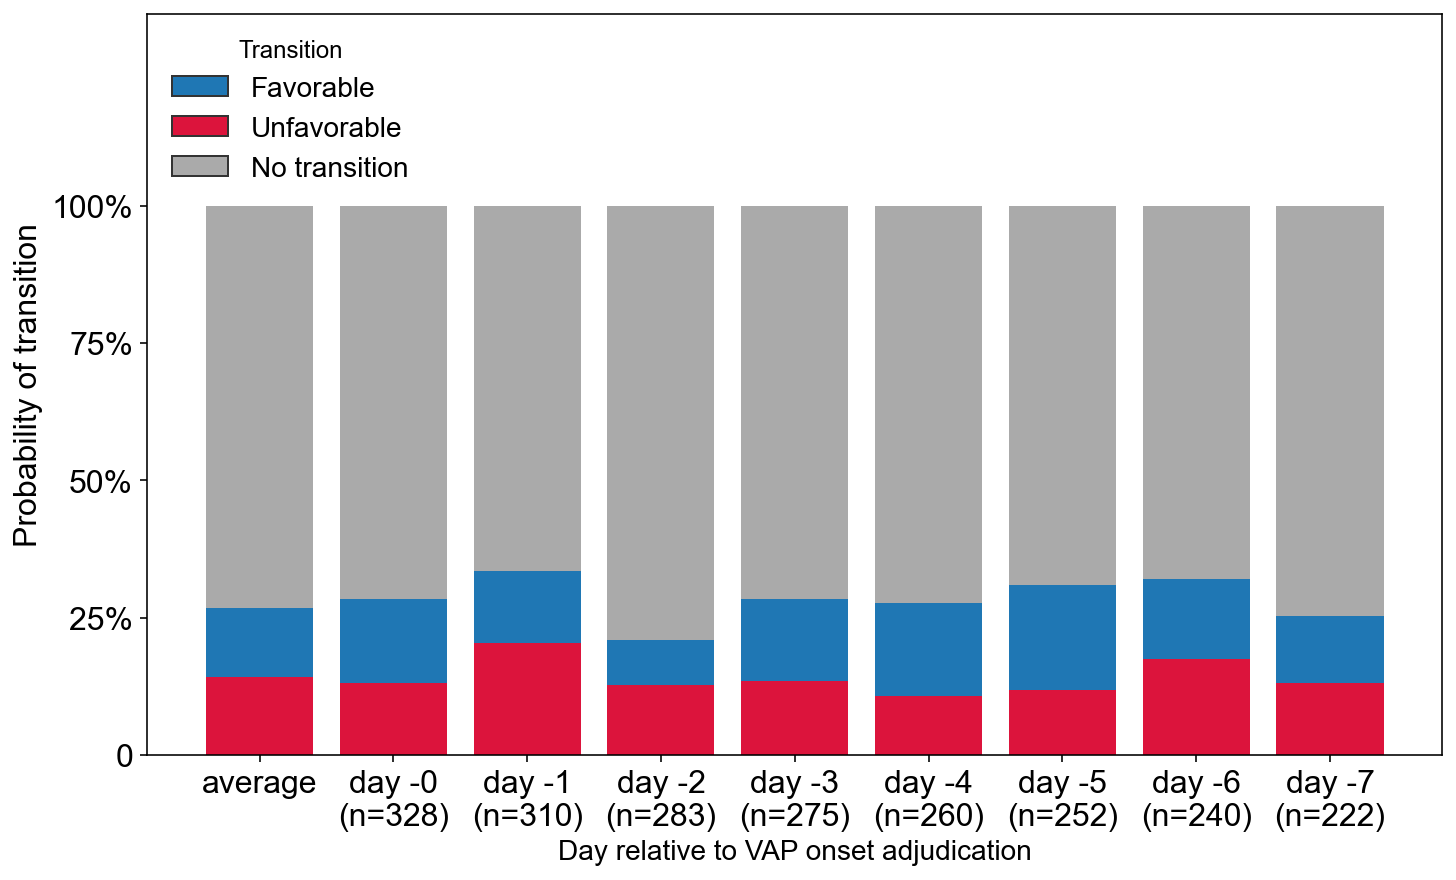

In [92]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.bar(plot_df.index, plot_df.bad_prob, color=DISCH_PALETTE[-1])
ax.bar(plot_df.index, plot_df.good_prob, color=DISCH_PALETTE[0], bottom=plot_df.bad_prob)
ax.bar(plot_df.index, plot_df.no_prob, color="#aaa", bottom=plot_df.bad_prob + plot_df.good_prob)
ax.set_xticks(list(range(9)))
ax.set_xticklabels(plot_df.category, size=16)
ax.set_ylabel("Probability of transition", size=16)
ax.set_ylim(0, 1.35)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels(["0", "25%", "50%", "75%", "100%"], size=16)
handles = [
    mpl.patches.Patch(color=DISCH_PALETTE[0], label="Favorable", ec="#333333"),
    mpl.patches.Patch(color=DISCH_PALETTE[-1], label="Unfavorable", ec="#333333"),
    mpl.patches.Patch(color="#aaa", label="No transition", ec="#333333")
]
ax.legend(
    handles=handles, 
    loc="upper left", 
    title="Transition", 
    frameon=False,
    fontsize=14,
    title_fontsize=12
);
ax.set_xlabel("Day relative to VAP onset adjudication", size=14)

dump_figure('days_before_vap_transition_likelihood.pdf')

In [217]:
plot_data = []

In [218]:
plot_data.append((
    "average",
    data.bad_transition.eq("bad").sum() / data.shape[0],
    data.bad_transition.eq("good").sum() / data.shape[0],
    (
        data.next_cluster.eq(-1)
        & data.Binary_outcome.eq("Alive")
    ).sum() / data.shape[0],
    (
        data.next_cluster.eq(-1)
        & data.Binary_outcome.eq("Died")
    ).sum() / data.shape[0]
))

In [219]:
for delta in range(-5, 8):
    vap_df = data.loc[data.Episode_category.eq("VAP") & data.Episode_is_cured.eq("Cured")].copy()
    vap_df["prev_day"] = vap_df.day - delta
    vap_df = vap_df.loc[vap_df.prev_day > 0].copy()
    vap_df["prev_day_idx"] = (
        vap_df.patient.astype(str) 
        + "/" + vap_df.stay.astype(str)
        + "/" + vap_df.prev_day.astype(str)
    )
    vap_df = vap_df.loc[vap_df.prev_day_idx.isin(data.index)]
    vap_df.prev_day_idx.isin(data.index).sum()
    day_before_vap = data.loc[vap_df.prev_day_idx]
    bad_prob = day_before_vap.bad_transition.eq("bad").sum() / day_before_vap.shape[0]
    good_prob = day_before_vap.bad_transition.eq("good").sum() / day_before_vap.shape[0]
    good_disch_prob = (
        day_before_vap.next_cluster.eq(-1)
        & day_before_vap.Binary_outcome.eq("Alive")
    ).sum() / day_before_vap.shape[0]
    bad_disch_prob = (
        day_before_vap.next_cluster.eq(-1)
        & day_before_vap.Binary_outcome.eq("Died")
    ).sum() / day_before_vap.shape[0]
    plot_data.append((
        f"day {-delta}\n(n={vap_df.shape[0]})",
        bad_prob,
        good_prob,
        bad_disch_prob,
        good_disch_prob
    ))

In [220]:
plot_df = pd.DataFrame(
    plot_data, 
    columns=["category", "bad_prob", "good_prob", "bad_disch_prob", "good_disch_prob"]
)

In [221]:
plot_df["no_prob"] = (
    1 - plot_df.bad_prob - plot_df.good_prob - plot_df.bad_disch_prob - plot_df.good_disch_prob
)

In [222]:
COLORS = {
    "bad_prob": DISCH_PALETTE[-1],
    "good_prob": DISCH_PALETTE[0],
    "bad_disch_prob": "black",
    "good_disch_prob": "darkgreen",
    "no_prob": "#aaa"
}

Text(0.5, 1.0, 'Cured VAP episodes only')

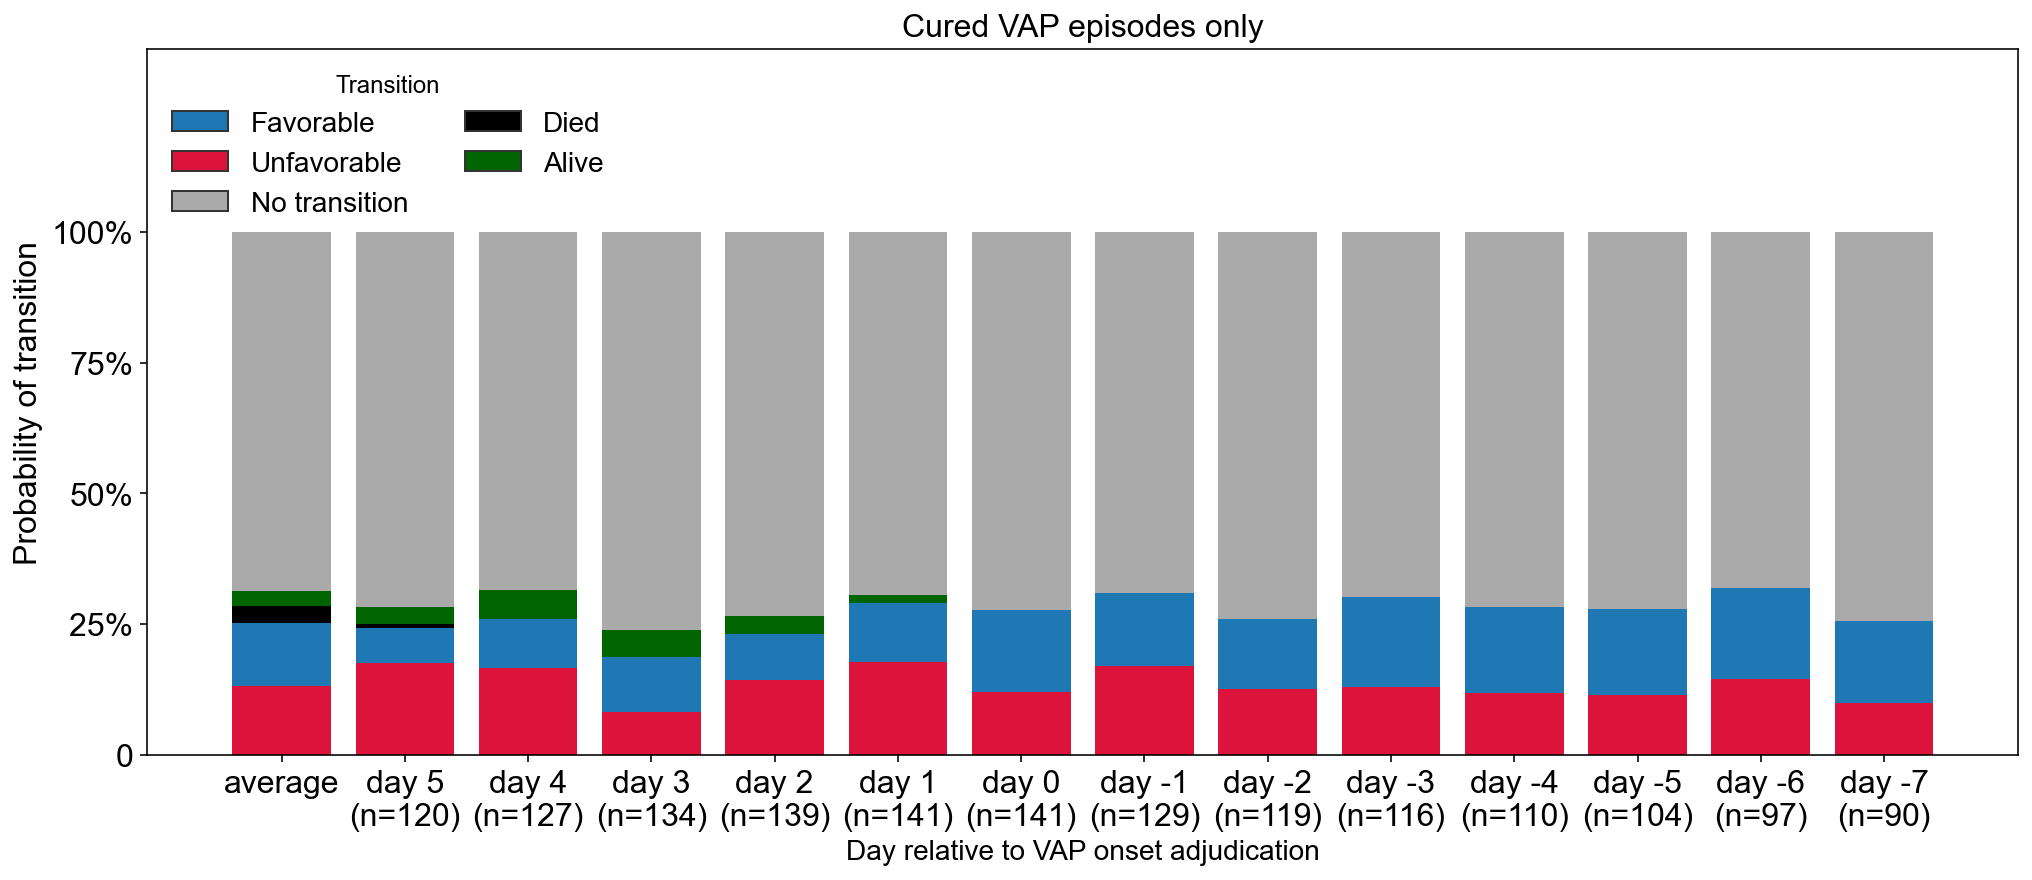

In [225]:
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)
bottom = pd.Series(0, index=plot_df.index)
for c in plot_df.columns[plot_df.columns.str.endswith("_prob")]:
    ax.bar(plot_df.index, plot_df[c], bottom=bottom, color=COLORS[c])
    bottom += plot_df[c]
ax.set_xticks(plot_df.index)
ax.set_xticklabels(plot_df.category, size=16)
ax.set_ylabel("Probability of transition", size=16)
ax.set_ylim(0, 1.35)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels(["0", "25%", "50%", "75%", "100%"], size=16)
handles = [
    mpl.patches.Patch(color=DISCH_PALETTE[0], label="Favorable", ec="#333333"),
    mpl.patches.Patch(color=DISCH_PALETTE[-1], label="Unfavorable", ec="#333333"),
    mpl.patches.Patch(color="#aaa", label="No transition", ec="#333333"),
    mpl.patches.Patch(color="black", label="Died", ec="#333333"),
    mpl.patches.Patch(color="darkgreen", label="Alive", ec="#333333"),
]
ax.legend(
    handles=handles, 
    loc="upper left", 
    title="Transition", 
    frameon=False,
    fontsize=14,
    title_fontsize=12,
    ncol=2
)
ax.set_xlabel("Day relative to VAP onset adjudication", size=14)
ax.set_title("Cured VAP episodes only", size=16)

In [226]:
plot_data = []

In [227]:
plot_data.append((
    "average",
    data.bad_transition.eq("bad").sum() / data.shape[0],
    data.bad_transition.eq("good").sum() / data.shape[0],
    (
        data.next_cluster.eq(-1)
        & data.Binary_outcome.eq("Alive")
    ).sum() / data.shape[0],
    (
        data.next_cluster.eq(-1)
        & data.Binary_outcome.eq("Died")
    ).sum() / data.shape[0]
))

In [228]:
for delta in range(-5, 8):
    vap_df = data.loc[data.Episode_category.eq("VAP") & data.Episode_is_cured.eq("Not cured")].copy()
    vap_df["prev_day"] = vap_df.day - delta
    vap_df = vap_df.loc[vap_df.prev_day > 0].copy()
    vap_df["prev_day_idx"] = (
        vap_df.patient.astype(str) 
        + "/" + vap_df.stay.astype(str)
        + "/" + vap_df.prev_day.astype(str)
    )
    vap_df = vap_df.loc[vap_df.prev_day_idx.isin(data.index)]
    vap_df.prev_day_idx.isin(data.index).sum()
    day_before_vap = data.loc[vap_df.prev_day_idx]
    bad_prob = day_before_vap.bad_transition.eq("bad").sum() / day_before_vap.shape[0]
    good_prob = day_before_vap.bad_transition.eq("good").sum() / day_before_vap.shape[0]
    good_disch_prob = (
        day_before_vap.next_cluster.eq(-1)
        & day_before_vap.Binary_outcome.eq("Alive")
    ).sum() / day_before_vap.shape[0]
    bad_disch_prob = (
        day_before_vap.next_cluster.eq(-1)
        & day_before_vap.Binary_outcome.eq("Died")
    ).sum() / day_before_vap.shape[0]
    plot_data.append((
        f"day {-delta}\n(n={vap_df.shape[0]})",
        bad_prob,
        good_prob,
        bad_disch_prob,
        good_disch_prob
    ))

In [229]:
plot_df = pd.DataFrame(
    plot_data, 
    columns=["category", "bad_prob", "good_prob", "bad_disch_prob", "good_disch_prob"]
)

In [230]:
plot_df["no_prob"] = (
    1 - plot_df.bad_prob - plot_df.good_prob - plot_df.bad_disch_prob - plot_df.good_disch_prob
)

Text(0.5, 1.0, 'Not cured VAP episodes only')

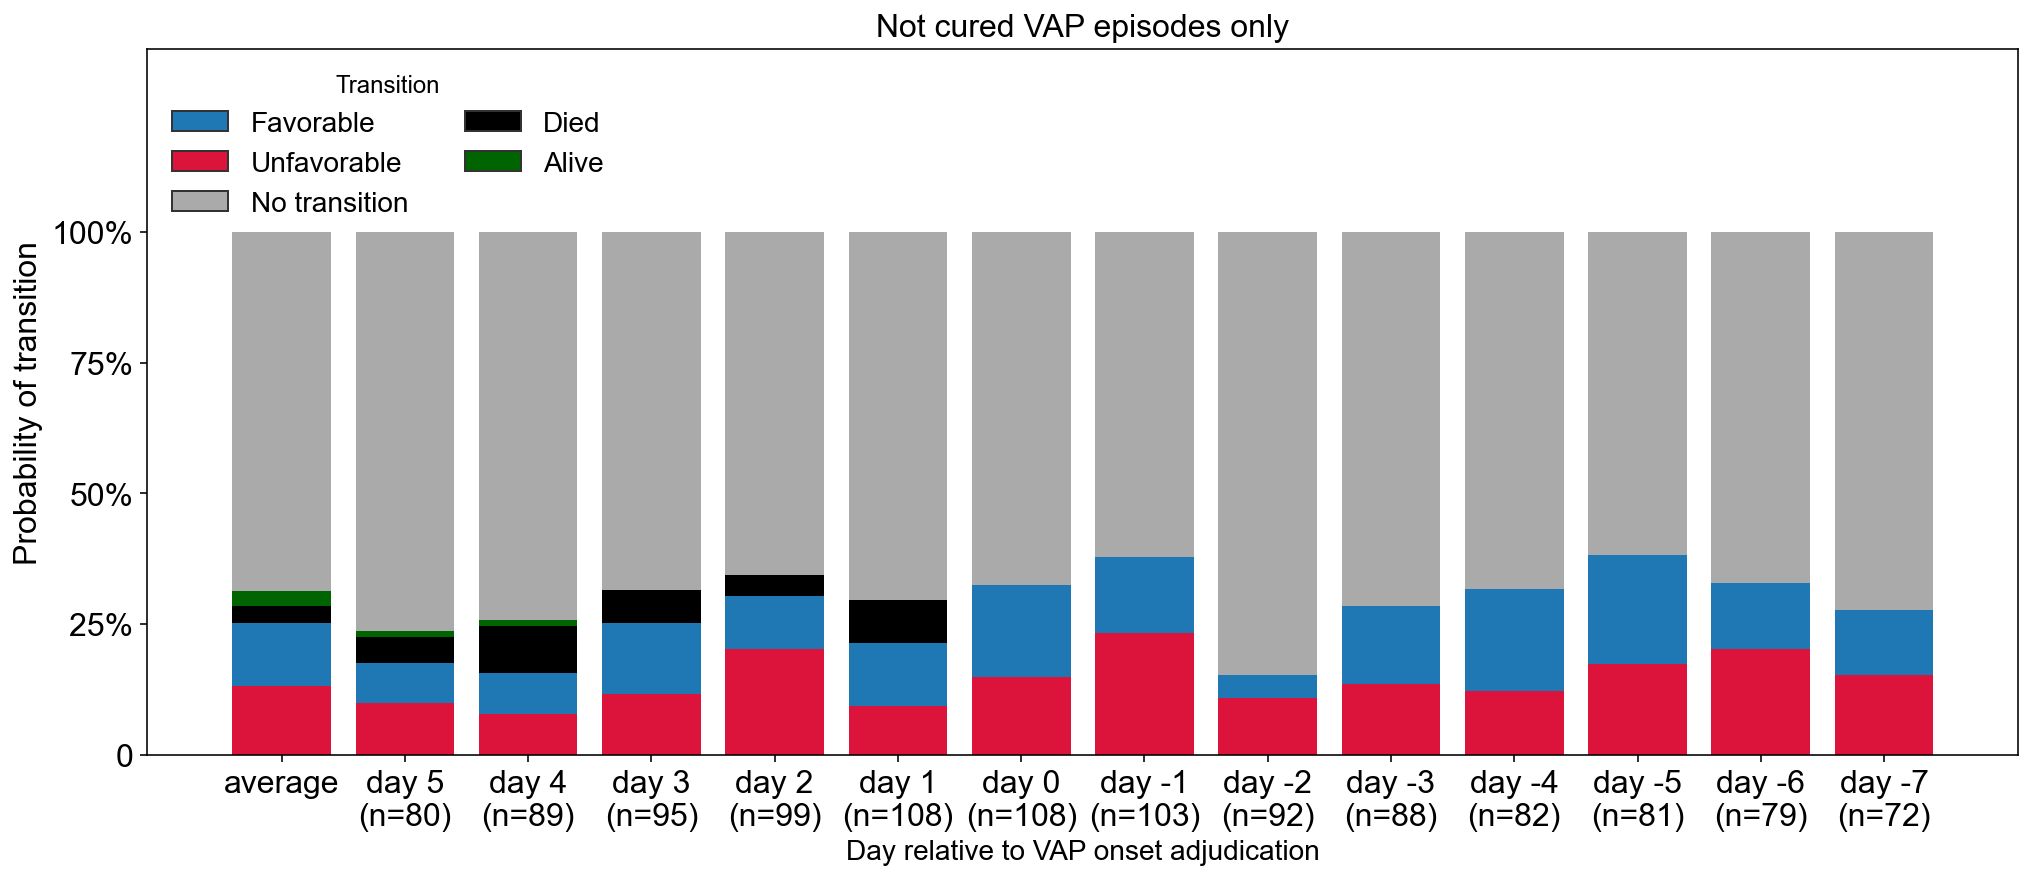

In [231]:
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)
bottom = pd.Series(0, index=plot_df.index)
for c in plot_df.columns[plot_df.columns.str.endswith("_prob")]:
    ax.bar(plot_df.index, plot_df[c], bottom=bottom, color=COLORS[c])
    bottom += plot_df[c]
ax.set_xticks(plot_df.index)
ax.set_xticklabels(plot_df.category, size=16)
ax.set_ylabel("Probability of transition", size=16)
ax.set_ylim(0, 1.35)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels(["0", "25%", "50%", "75%", "100%"], size=16)
handles = [
    mpl.patches.Patch(color=DISCH_PALETTE[0], label="Favorable", ec="#333333"),
    mpl.patches.Patch(color=DISCH_PALETTE[-1], label="Unfavorable", ec="#333333"),
    mpl.patches.Patch(color="#aaa", label="No transition", ec="#333333"),
    mpl.patches.Patch(color="black", label="Died", ec="#333333"),
    mpl.patches.Patch(color="darkgreen", label="Alive", ec="#333333"),
]
ax.legend(
    handles=handles, 
    loc="upper left", 
    title="Transition", 
    frameon=False,
    fontsize=14,
    title_fontsize=12,
    ncol=2
)
ax.set_xlabel("Day relative to VAP onset adjudication", size=14)
ax.set_title("Not cured VAP episodes only", size=16)

In [188]:
plot_data = []

In [189]:
plot_data.append((
    "average",
    data.bad_transition.eq("bad").sum() / data.next_cluster.ne(-1).sum(),
    data.bad_transition.eq("good").sum() / data.next_cluster.ne(-1).sum(),
))

In [190]:
for delta in range(-5, 8):
    vap_df = data.loc[data.Episode_category.eq("VAP") & data.Episode_is_cured.eq("Not cured")].copy()
    vap_df["prev_day"] = vap_df.day - delta
    vap_df = vap_df.loc[vap_df.prev_day > 0].copy()
    vap_df["prev_day_idx"] = (
        vap_df.patient.astype(str) 
        + "/" + vap_df.stay.astype(str)
        + "/" + vap_df.prev_day.astype(str)
    )
    vap_df = vap_df.loc[vap_df.prev_day_idx.isin(data.index)]
    vap_df.prev_day_idx.isin(data.index).sum()
    day_before_vap = data.loc[vap_df.prev_day_idx]
    bad_prob = day_before_vap.bad_transition.eq("bad").sum() / day_before_vap.next_cluster.ne(-1).sum()
    good_prob = day_before_vap.bad_transition.eq("good").sum() / day_before_vap.next_cluster.ne(-1).sum()
    plot_data.append((
        f"day {-delta}\n(n={vap_df.shape[0]})",
        bad_prob,
        good_prob
    ))

In [191]:
plot_df = pd.DataFrame(plot_data, columns=["category", "bad_prob", "good_prob"])

In [192]:
plot_df["no_prob"] = 1 - plot_df.bad_prob - plot_df.good_prob

Text(0.5, 1.0, 'Not cured VAP episodes only')

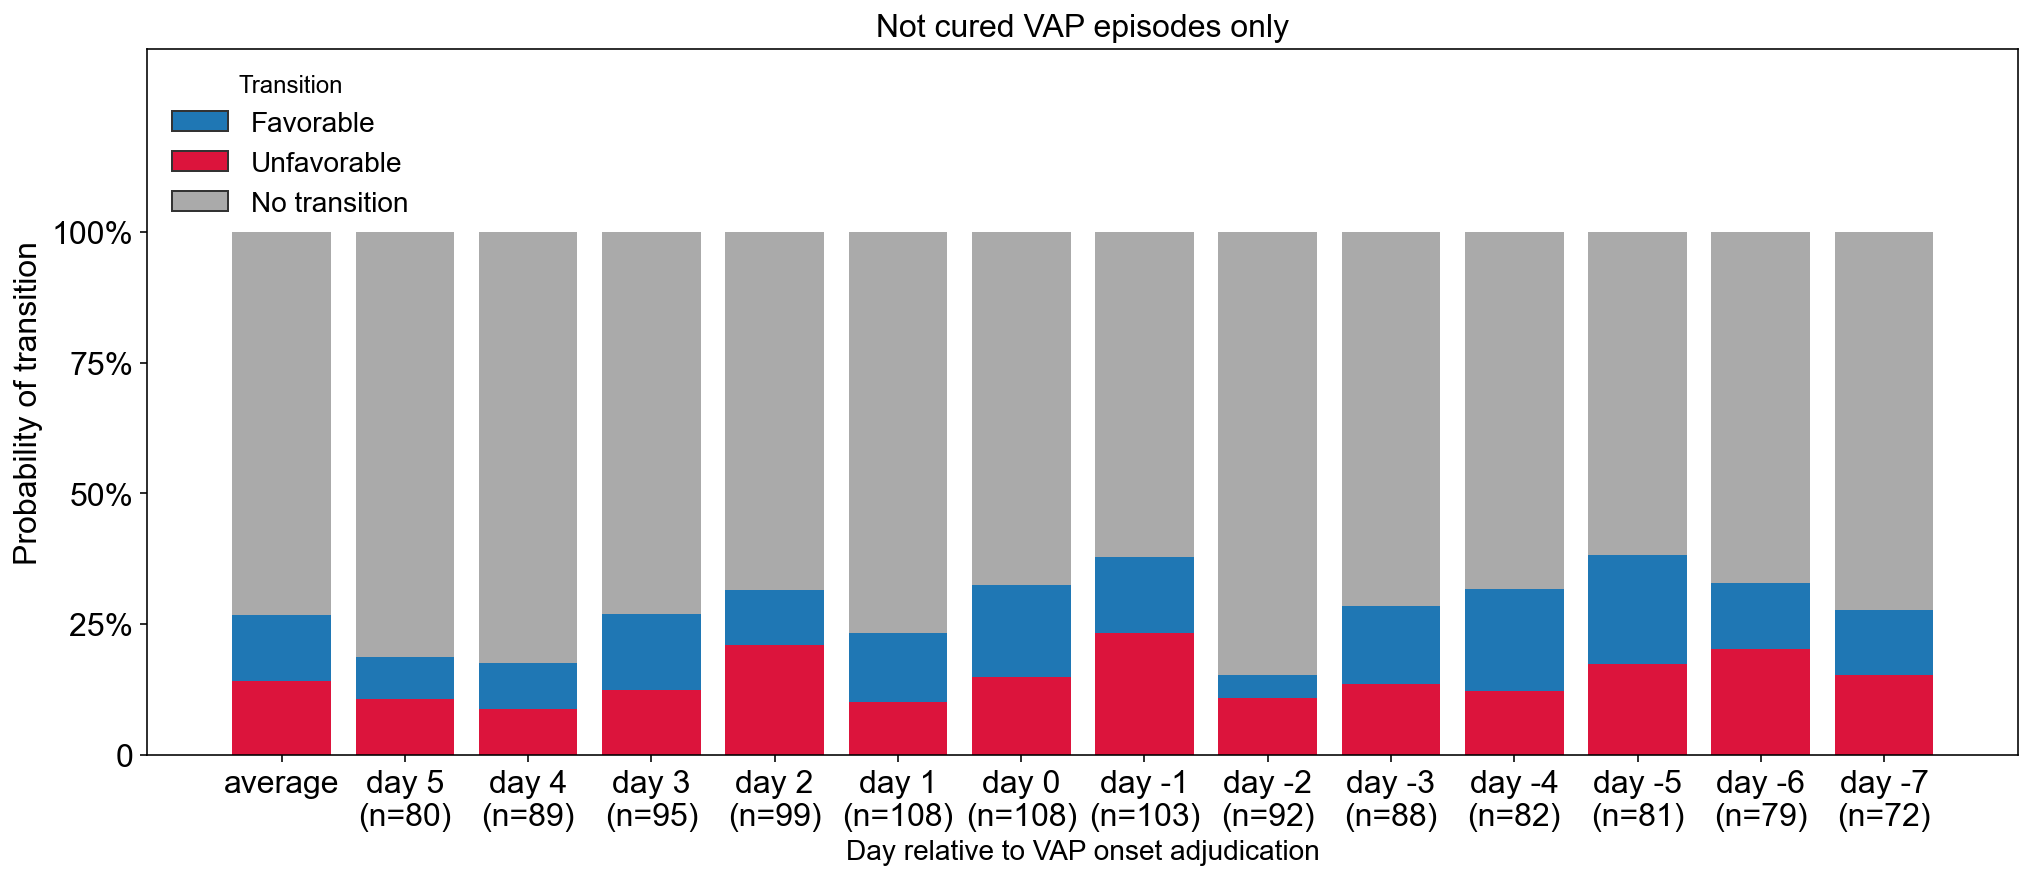

In [193]:
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)
ax.bar(plot_df.index, plot_df.bad_prob, color=DISCH_PALETTE[-1])
ax.bar(plot_df.index, plot_df.good_prob, color=DISCH_PALETTE[0], bottom=plot_df.bad_prob)
ax.bar(plot_df.index, plot_df.no_prob, color="#aaa", bottom=plot_df.bad_prob + plot_df.good_prob)
ax.set_xticks(plot_df.index)
ax.set_xticklabels(plot_df.category, size=16)
ax.set_ylabel("Probability of transition", size=16)
ax.set_ylim(0, 1.35)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels(["0", "25%", "50%", "75%", "100%"], size=16)
handles = [
    mpl.patches.Patch(color=DISCH_PALETTE[0], label="Favorable", ec="#333333"),
    mpl.patches.Patch(color=DISCH_PALETTE[-1], label="Unfavorable", ec="#333333"),
    mpl.patches.Patch(color="#aaa", label="No transition", ec="#333333")
]
ax.legend(
    handles=handles, 
    loc="upper left", 
    title="Transition", 
    frameon=False,
    fontsize=14,
    title_fontsize=12
)
ax.set_xlabel("Day relative to VAP onset adjudication", size=14)
ax.set_title("Not cured VAP episodes only", size=16)

In [194]:
plot_data = []

In [195]:
plot_data.append((
    "average",
    data.bad_transition.eq("bad").sum() / data.next_cluster.ne(-1).sum(),
    data.bad_transition.eq("good").sum() / data.next_cluster.ne(-1).sum(),
))

In [196]:
for delta in range(-5, 8):
    vap_df = data.loc[data.Episode_category.eq("VAP")].copy()
    vap_df["prev_day"] = vap_df.day - delta
    vap_df = vap_df.loc[vap_df.prev_day > 0].copy()
    vap_df["prev_day_idx"] = (
        vap_df.patient.astype(str) 
        + "/" + vap_df.stay.astype(str)
        + "/" + vap_df.prev_day.astype(str)
    )
    vap_df = vap_df.loc[vap_df.prev_day_idx.isin(data.index)]
    day_before_vap = data.loc[vap_df.prev_day_idx]
    bad_prob = day_before_vap.bad_transition.eq("bad").sum() / day_before_vap.next_cluster.ne(-1).sum()
    good_prob = day_before_vap.bad_transition.eq("good").sum() / day_before_vap.next_cluster.ne(-1).sum()
    plot_data.append((
        f"day {-delta}\n(n={vap_df.shape[0]})",
        bad_prob,
        good_prob
    ))

In [197]:
plot_df = pd.DataFrame(plot_data, columns=["category", "bad_prob", "good_prob"])

In [198]:
plot_df["no_prob"] = 1 - plot_df.bad_prob - plot_df.good_prob

Text(0.5, 0, 'Day relative to VAP onset adjudication')

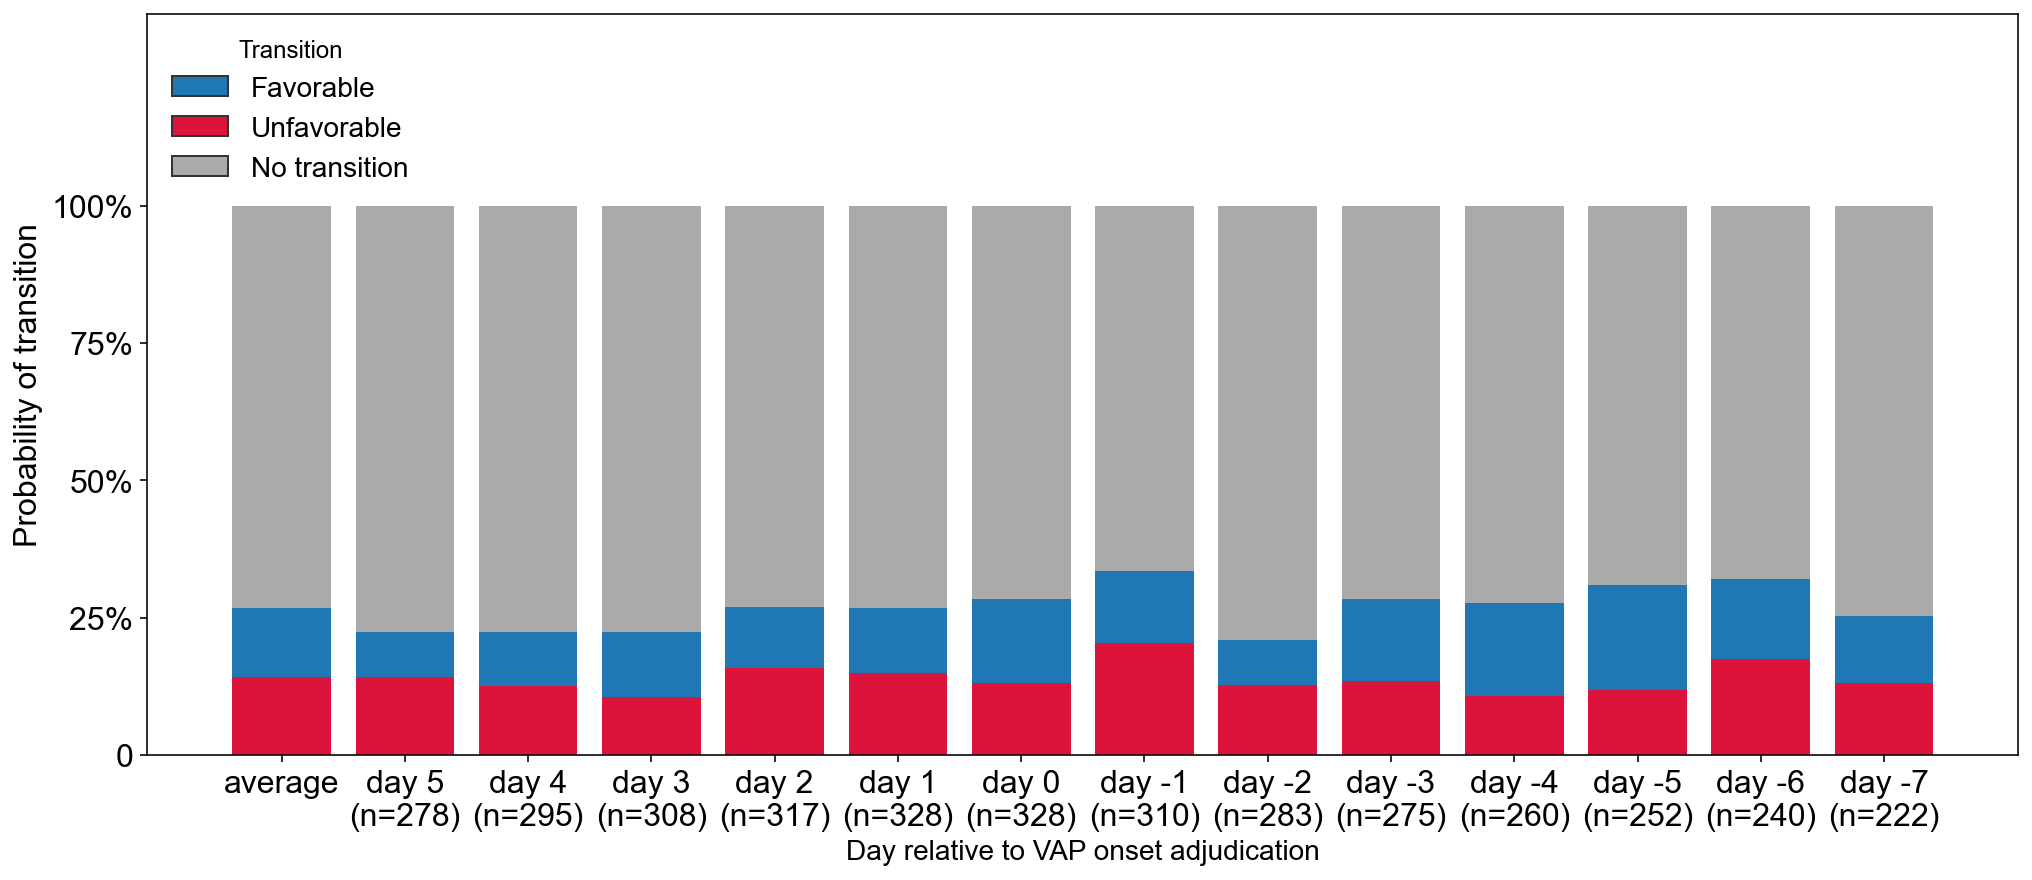

In [199]:
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)
ax.bar(plot_df.index, plot_df.bad_prob, color=DISCH_PALETTE[-1])
ax.bar(plot_df.index, plot_df.good_prob, color=DISCH_PALETTE[0], bottom=plot_df.bad_prob)
ax.bar(plot_df.index, plot_df.no_prob, color="#aaa", bottom=plot_df.bad_prob + plot_df.good_prob)
ax.set_xticks(plot_df.index)
ax.set_xticklabels(plot_df.category, size=16)
ax.set_ylabel("Probability of transition", size=16)
ax.set_ylim(0, 1.35)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels(["0", "25%", "50%", "75%", "100%"], size=16)
handles = [
    mpl.patches.Patch(color=DISCH_PALETTE[0], label="Favorable", ec="#333333"),
    mpl.patches.Patch(color=DISCH_PALETTE[-1], label="Unfavorable", ec="#333333"),
    mpl.patches.Patch(color="#aaa", label="No transition", ec="#333333")
]
ax.legend(
    handles=handles, 
    loc="upper left", 
    title="Transition", 
    frameon=False,
    fontsize=14,
    title_fontsize=12
);
ax.set_xlabel("Day relative to VAP onset adjudication", size=14)